In [1]:
import os
import sys
import pathlib
import math
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline 

import numpy as np
import pandas as pd

from IPython.display import clear_output
from datetime import datetime
import re

In [2]:
ids = os.listdir("E:/UG4data/Smile")
ids.remove("PRB002")
ids.remove("PRB111")
long_ids = [f[:-14] for f in os.listdir("E:/UG4data/NHS_processed")]

In [3]:
NEW_ACTIVITY_DESCRIPTIONS = {
    0: "Ascending stairs",
    1: 'Cycling',
    2: 'Descending stairs',
    3: 'Lying on back',
    4: 'Lying on left side',
    5: 'Lying on right side',
    6: 'Lying on stomach',
    7: 'Movement',
    8: 'Not worn',
    9: 'Running',
    10: 'Shuffling',
    11: 'Sitting/Standing',
    12: 'Walking'
}
stationary_activities = [3, 4, 5, 6, 11]

## Functions

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM, SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from scipy.cluster.hierarchy import dendrogram, linkage
# import tensorflow as tf

In [6]:
def load_static_data(id):
    data = pd.DataFrame()
    for long_id in [f for f in long_ids if f.startswith(id)]:
        df = pd.read_csv(f"E:/UG4data/NHS_HAR_r30s/{long_id}_r30s.csv", parse_dates=["timestamp"], index_col=["timestamp"])
        df["date"] = int(re.search(r'\((\d+)\)', long_id).group(1))
        data = pd.concat([data, df])
#     # Choose only lying data
#     data = data[data["final_class"].isin([3, 4, 5, 6])]
    # Choose only stationary data
    data = data[data["final_class"].isin(stationary_activities)]
    l = len(data)
    print(f"{id} has {l} rows,")
    data.dropna(how='any', inplace=True)
    print(f"dropped {l - len(data)} rows with NA.")
    data = data.sort_values("date")
    return data

In [7]:
def redirect(df, col='isSleep'):
    day = df[(df.index.hour <= 20) & (df.index.hour >= 7)]
    night = df[(df.index.hour >= 22) | (df.index.hour <= 5)]
    if day[col].sum() / len(day) > 0.3 and night[col].sum() / len(night) < 0.7:
        print("Redirected")
        df[col] = df[col].map({0:1, 1:0})
    return df

def unsupervised(df, model):
    # Standardize the data to have mean=0 and standard deviation=1
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)
    
    # Unsupervised learning
    if model == 'kmeans':
        kmeans = KMeans(n_clusters=2, random_state=42)
        return kmeans.fit_predict(data_scaled)
    elif model == 'EM_Cluster':
        gmm = GaussianMixture(n_components=2, random_state=42)
        gmm.fit(data_scaled)
        return gmm.predict(data_scaled)
    elif model == 'DBSCAN':
        dbscan_model = DBSCAN(eps=0.5, min_samples=5)
        return dbscan_model.fit_predict(data_scaled)
    elif model == 'PCA':
        pca = PCA(n_components=1)
        return pca.fit_transform(data_scaled)

def split_sets(df, features, label, test_size=0.2):
    # Standardize the data to have mean=0 and standard deviation=1
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)
    # X_train, X_test, y_train, y_test
    return train_test_split(df[features], df[label], test_size=test_size, random_state=42)

def supervised(X_train, y_train, model, hyperparameter=[]):
    # Supervised learning
    if model == 'random_forest':
        classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        return classifier.fit(X_train, y_train)
    elif model =='naive_bayes':
        gnb = GaussianNB()
        return gnb.fit(X_train, y_train)
    elif model == 'svm_linear':
        C = 1.0 if not hyperparameter else hyperparameter[0]
        svm_classifier = SVC(kernel='linear', C=C, random_state=42)
        return svm_classifier.fit(X_train, y_train)
    elif model == 'svm_rbf':
        C = 1.0 if not hyperparameter else hyperparameter[0]
        gamma = 1.0 if not hyperparameter else hyperparameter[1]
        svm_classifier = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)
        return svm_classifier.fit(X_train, y_train)
    elif model == 'neural_networks':
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=42)
        return clf.fit(X_train, y_train)

def find_accuracy(predict, label):
    # Evaluate the model's accuracy
    accuracy = accuracy_score(label, predict)
    confusion_mat = confusion_matrix(label, predict)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(confusion_mat)

In [8]:
def plot_predict_heatmap(df, model, id, save=""):
    heat_map = df.groupby([df.index.date, df.index.time])[model].mean().unstack()
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(heat_map, vmin = 0, vmax = 1, cmap=sns.color_palette(['orange', 'steelblue']))
    ax.set_ylabel("ID")
    ax.set_xlabel("Timestamp(hrs)")
    ax.set_title(f"Classification of {id} sleep-wake episodes using {model}")
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(["Awake", "Sleeping"])
    plt.tight_layout()
    if save:
        plt.savefig(f"results/NHS/graphs/sleep-wake/{save}{save[:-1]}_{id}.png", dpi=300)
    plt.show()

def plot_clustering(df, predict, label, x, y, title):
    # Visualize the clustering results
    plt.scatter(df[x], df[y], c=df[predict], cmap=colors.ListedColormap(['green', 'darkred']), s=20)
    wrong_labels = df[df[label] != df[predict]][df[predict]==0]
    plt.scatter(wrong_labels[x], wrong_labels[y], c='red', s=20, marker='x')
    wrong_labels = df[df[label] != df[predict]][df[predict]==1]
    plt.scatter(wrong_labels[x], wrong_labels[y], c='lightgreen', s=20, marker='x')
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.tight_layout()
    plt.show()

## Unsupervised clustering

In [40]:
id = "PRB006"
data = load_static_data(id)
data

PRB006 has 54568 rows,
dropped 2140 rows with NA.


x         y         z  breathingSignal  \
timestamp                                                            
2022-04-25 12:59:30 -0.501799 -0.615314  0.625930        -0.002604   
2022-04-25 18:54:00 -0.511973 -0.562066  0.653635         0.042017   
2022-04-25 18:53:30 -0.362898 -0.517488  0.764316        -0.021348   
2022-04-25 18:53:00 -0.429284 -0.507387  0.741403         0.021327   
2022-04-25 18:52:30 -0.372563 -0.644092  0.490624         0.037911   
...                       ...       ...       ...              ...   
2022-05-26 02:40:00  0.427172 -0.251351  0.800546        -0.003899   
2022-05-26 02:39:30  0.426544 -0.250448  0.801016         0.002932   
2022-05-26 02:39:00  0.427523 -0.248536  0.800962        -0.005858   
2022-05-26 02:38:00  0.435717 -0.243217  0.797700        -0.003264   
2022-05-26 03:27:00 -0.343093  0.128021 -0.974045        -0.001869   

                     breathingRate  activityLevel  final_class  date  
timestamp                                                             
2022-04-25 12:59:30      19.355118       0.018764         11.0     2  
2022-04-25 18:54:00      24.481091       0.038169         11.0     2  
2022-04-25 18:53:30      21.202308       0.017277         11.0     2  
2022-04-25 18:53:00      16.325909       0.023044         11.0     2  
2022-04-25 18:52:30      22.052588       0.120992         11.0     2  
...                            ...            ...          ...   ...  
2022-05-26 02:40:00      16.638920       0.014393          5.0    33  
2022-05-26 02:39:30      16.973318       0.013537          5.0    33  
2022-05-26 02:39:00      17.613491       0.016694          5.0    33  
2022-05-26 02:38:00      18.183149       0.014530          5.0    33  
2022-05-26 03:27:00      19.801682       0.007517          6.0    33  

[52428 rows x 8 columns]

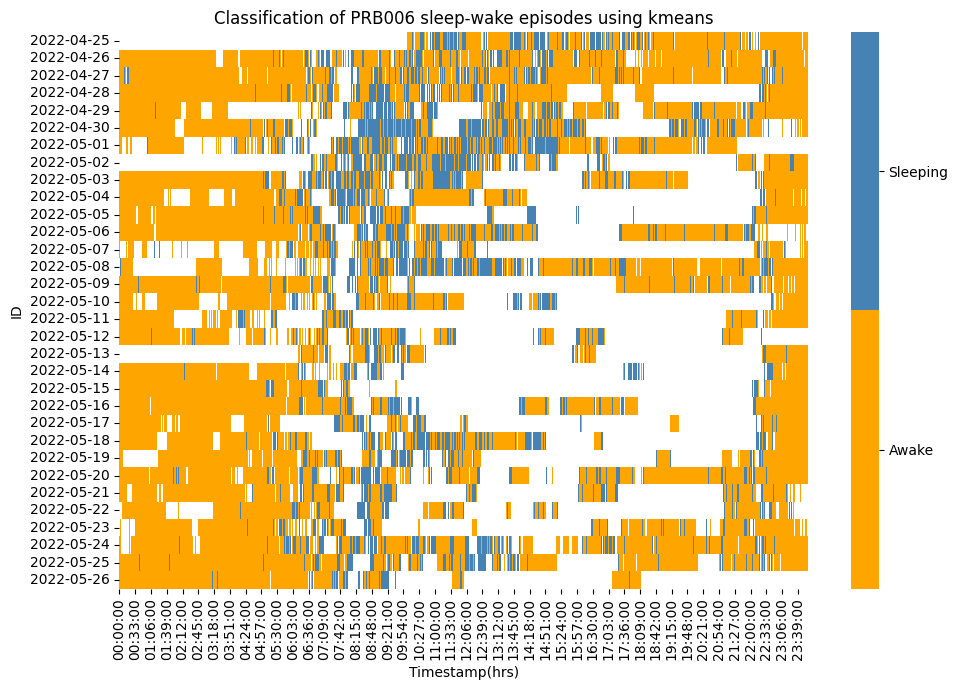

In [41]:
selected_features = data[['breathingRate', 'activityLevel']]
data['kmeans'] = unsupervised(selected_features, 'kmeans')
# data = redirect(data, 'kmeans')
plot_predict_heatmap(data, 'kmeans', id, 'clustering/')

## Using secondary variables

In [13]:
def load_data_secondary(id):
    data = pd.DataFrame()
    for long_id in [f for f in long_ids if f.startswith(id)]:
        path = f"E:/UG4data/NHS_HAR_secondary/{long_id}_secondary.csv"
        if os.path.exists(path):
            df = pd.read_csv(path, parse_dates=["timestamp"], index_col=["timestamp"])
            df["date"] = int(re.search(r'\((\d+)\)', long_id).group(1))
            data = pd.concat([data, df])
#     # Choose only lying data
#     data = data[data["final_class"].isin([3, 4, 5, 6])]
    # Choose only stationary data
    data = data[data["final_class"].isin(stationary_activities)]
    l = len(data)
    print(f"{id} has {l} rows,")
#     # Choose only valid data
#     data = data[data["final_class"] != 8]
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(how='all', axis=1, inplace=True)
    data.dropna(how='any', inplace=True)
    print(f"dropped {l - len(data)} rows with NA.")
    data = data.sort_values("date")
    data['position'] = 0
    data.loc[data['final_class'].isin(stationary_activities), 'position'] = 1
    data.loc[data['final_class'] == 11, 'position'] = 0
    return data

In [14]:
data = load_data_secondary('PRB003')
data

PRB003 has 83629 rows,
dropped 23693 rows with NA.


BR_md    BR_mean     BR_std    BR_cov     AL_md  \
timestamp                                                                  
2021-08-18 10:33:00  16.883728  18.682450  10.962743  0.586794  0.086537   
2021-08-18 19:37:30  13.183714  15.003569   8.884756  0.592176  0.028220   
2021-08-18 19:38:30  15.501986  17.605890   7.219095  0.410039  0.033523   
2021-08-18 19:39:00  21.320257  20.619026   2.494808  0.120995  0.024615   
2021-08-18 19:40:00  13.903503  14.288771   1.045093  0.073141  0.039271   
...                        ...        ...        ...       ...       ...   
2021-11-02 08:41:30  27.483250  27.559066   1.673683  0.060731  0.007059   
2021-11-02 12:33:30  36.071764  36.071764   7.287597  0.202031  0.009335   
2021-11-02 13:15:30  28.540297  29.438788  11.363512  0.386005  0.007755   
2021-11-02 08:16:30  22.526449  22.526449   5.621861  0.249567  0.008347   
2021-11-02 12:34:00  22.274729  22.274729   2.350838  0.105538  0.006592   

                      AL_mean    AL_std    AL_cov        RRV    RRV3ANN  \
timestamp                                                                 
2021-08-18 10:33:00  0.091277  0.042300  0.463423  64.888426  27.089741   
2021-08-18 19:37:30  0.042252  0.032215  0.762456  31.456809  21.904732   
2021-08-18 19:38:30  0.047814  0.036925  0.772251  56.456036  28.752240   
2021-08-18 19:39:00  0.025367  0.005467  0.215518  50.020142  29.144889   
2021-08-18 19:40:00  0.069005  0.056352  0.816640  38.812797  27.840032   
...                       ...       ...       ...        ...        ...   
2021-11-02 08:41:30  0.011737  0.009031  0.769497  58.873127  40.368070   
2021-11-02 12:33:30  0.015357  0.014871  0.968327  59.849844  39.795684   
2021-11-02 13:15:30  0.011238  0.007498  0.667238  49.825903  37.811315   
2021-11-02 08:16:30  0.013612  0.014324  1.052290  52.999327  37.110093   
2021-11-02 12:34:00  0.008418  0.008809  1.046537  62.609599  39.864325   

                     final_class  date  position  
timestamp                                         
2021-08-18 10:33:00         11.0     1         0  
2021-08-18 19:37:30         11.0     1         0  
2021-08-18 19:38:30         11.0     1         0  
2021-08-18 19:39:00         11.0     1         0  
2021-08-18 19:40:00         11.0     1         0  
...                          ...   ...       ...  
2021-11-02 08:41:30          3.0    48         1  
2021-11-02 12:33:30          3.0    48         1  
2021-11-02 13:15:30          3.0    48         1  
2021-11-02 08:16:30          3.0    48         1  
2021-11-02 12:34:00          3.0    48         1  

[59936 rows x 13 columns]

In [15]:
data.describe()

BR_md       BR_mean        BR_std        BR_cov         AL_md  \
count  59936.000000  59936.000000  59936.000000  59936.000000  59936.000000   
mean      19.686593     20.043198      4.938872      0.244749      0.050266   
std        3.873186      3.663852      3.042082      0.139038      0.062930   
min        6.746001      6.946335      0.000000      0.000000      0.005658   
25%       17.297033     17.707368      2.449716      0.129704      0.014273   
50%       19.573288     19.959431      4.352874      0.230599      0.021470   
75%       21.875660     22.164645      6.930971      0.334748      0.056268   
max       43.752056     40.900103     24.387660      1.025858      0.736377   

            AL_mean        AL_std        AL_cov           RRV       RRV3ANN  \
count  59936.000000  59936.000000  59936.000000  59936.000000  59936.000000   
mean       0.064723      0.042094      0.525646     43.750061     28.202509   
std        0.075732      0.060976      0.390088     12.551657      6.156757   
min        0.005857      0.000000      0.000000      1.299231      3.738571   
25%        0.016100      0.003188      0.203935     34.921393     23.948717   
50%        0.029403      0.017644      0.421848     44.640752     27.909165   
75%        0.082307      0.053495      0.735753     53.068569     32.119988   
max        0.565315      0.878125      3.233342     77.268335     47.457309   

        final_class          date      position  
count  59936.000000  59936.000000  59936.000000  
mean       8.257291     20.584707      0.451665  
std        3.131146     13.232745      0.497662  
min        3.000000      1.000000      0.000000  
25%        6.000000      8.000000      0.000000  
50%       11.000000     19.000000      0.000000  
75%       11.000000     31.000000      1.000000  
max       11.000000     48.000000      1.000000

### Clustering

In [16]:
load_data_secondary('PRB003')

PRB003 has 83629 rows,
dropped 23693 rows with NA.


BR_md    BR_mean     BR_std    BR_cov     AL_md  \
timestamp                                                                  
2021-08-18 10:33:00  16.883728  18.682450  10.962743  0.586794  0.086537   
2021-08-18 19:37:30  13.183714  15.003569   8.884756  0.592176  0.028220   
2021-08-18 19:38:30  15.501986  17.605890   7.219095  0.410039  0.033523   
2021-08-18 19:39:00  21.320257  20.619026   2.494808  0.120995  0.024615   
2021-08-18 19:40:00  13.903503  14.288771   1.045093  0.073141  0.039271   
...                        ...        ...        ...       ...       ...   
2021-11-02 08:41:30  27.483250  27.559066   1.673683  0.060731  0.007059   
2021-11-02 12:33:30  36.071764  36.071764   7.287597  0.202031  0.009335   
2021-11-02 13:15:30  28.540297  29.438788  11.363512  0.386005  0.007755   
2021-11-02 08:16:30  22.526449  22.526449   5.621861  0.249567  0.008347   
2021-11-02 12:34:00  22.274729  22.274729   2.350838  0.105538  0.006592   

                      AL_mean    AL_std    AL_cov        RRV    RRV3ANN  \
timestamp                                                                 
2021-08-18 10:33:00  0.091277  0.042300  0.463423  64.888426  27.089741   
2021-08-18 19:37:30  0.042252  0.032215  0.762456  31.456809  21.904732   
2021-08-18 19:38:30  0.047814  0.036925  0.772251  56.456036  28.752240   
2021-08-18 19:39:00  0.025367  0.005467  0.215518  50.020142  29.144889   
2021-08-18 19:40:00  0.069005  0.056352  0.816640  38.812797  27.840032   
...                       ...       ...       ...        ...        ...   
2021-11-02 08:41:30  0.011737  0.009031  0.769497  58.873127  40.368070   
2021-11-02 12:33:30  0.015357  0.014871  0.968327  59.849844  39.795684   
2021-11-02 13:15:30  0.011238  0.007498  0.667238  49.825903  37.811315   
2021-11-02 08:16:30  0.013612  0.014324  1.052290  52.999327  37.110093   
2021-11-02 12:34:00  0.008418  0.008809  1.046537  62.609599  39.864325   

                     final_class  date  position  
timestamp                                         
2021-08-18 10:33:00         11.0     1         0  
2021-08-18 19:37:30         11.0     1         0  
2021-08-18 19:38:30         11.0     1         0  
2021-08-18 19:39:00         11.0     1         0  
2021-08-18 19:40:00         11.0     1         0  
...                          ...   ...       ...  
2021-11-02 08:41:30          3.0    48         1  
2021-11-02 12:33:30          3.0    48         1  
2021-11-02 13:15:30          3.0    48         1  
2021-11-02 08:16:30          3.0    48         1  
2021-11-02 12:34:00          3.0    48         1  

[59936 rows x 13 columns]

PRB006 has 54508 rows,
dropped 3397 rows with NA.
Redirected


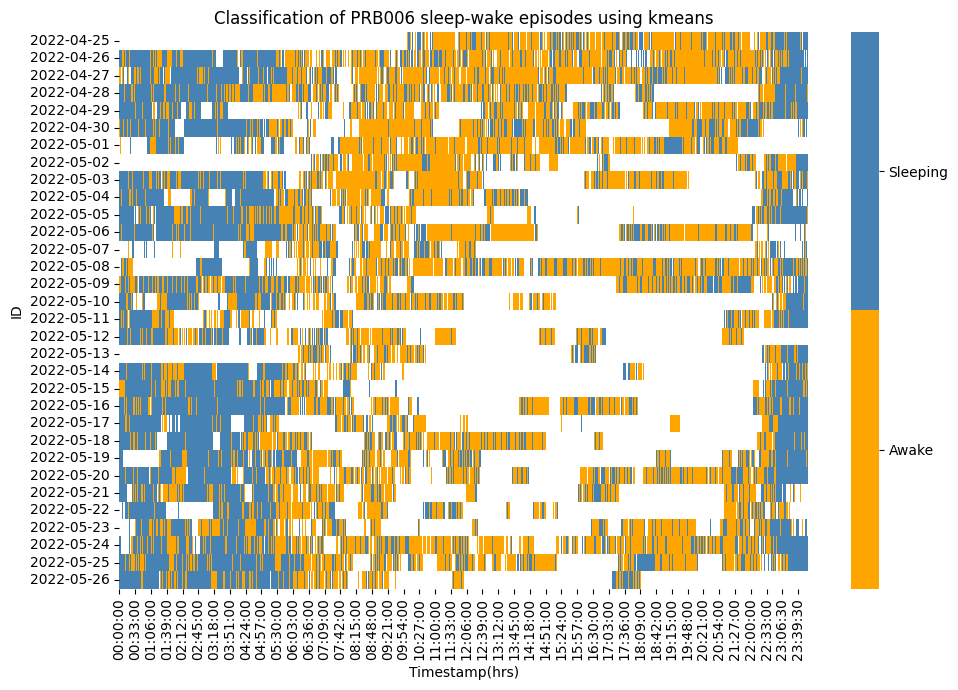

In [18]:
id = 'PRB006'
data = load_data_secondary(id)
data['kmeans'] = unsupervised(data[['RRV3ANN']], 'kmeans')
data = redirect(data, 'kmeans')
plot_predict_heatmap(data, 'kmeans', id)

### Trained by labelled data

PRB006 has 54508 rows,
dropped 3397 rows with NA.


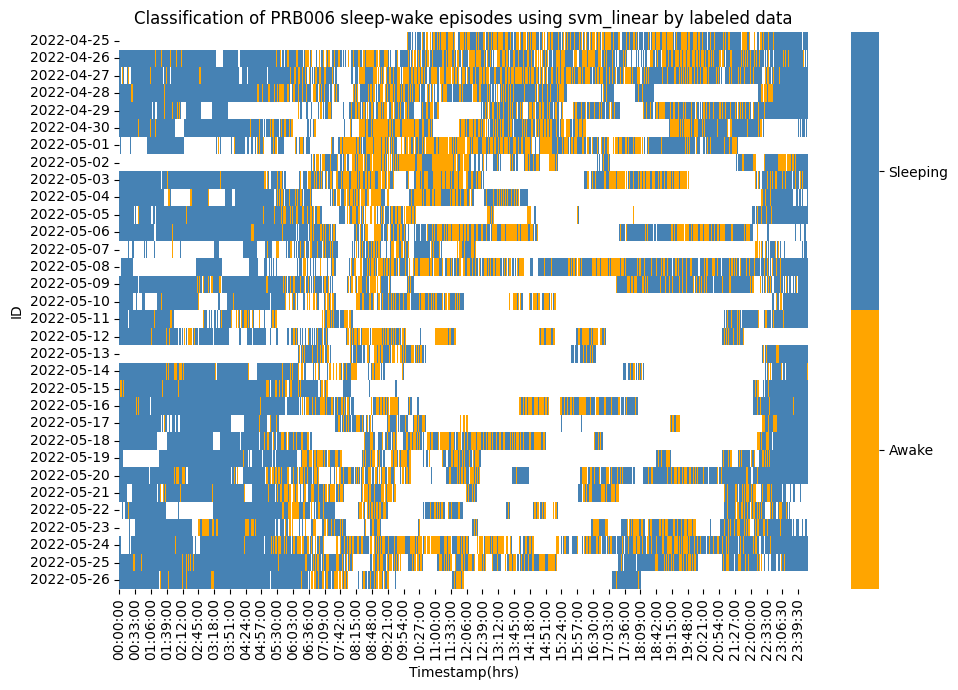

In [43]:
id = 'PRB006'
data = load_data_secondary(id)
labelled_df = pd.read_csv("APCAPS_clean_training_data.csv")[:606]

# Separate features and labels
X_train = labelled_df.drop('sleepWake', axis=1)
y_train = labelled_df['sleepWake']
X_test = data[['RRV3ANN', 'BR_std', 'BR_cov', 'AL_std']].rename({
    'BR_std': 'epochSDBR', 'BR_cov': 'BRSDCoeff', 'AL_std': 'epochSDAL'}, axis=1)

model = supervised(X_train, y_train, 'svm_linear')
data['svm_linear'] = model.predict(X_test)
plot_predict_heatmap(data, 'svm_linear', id, 'supervised/')

## Labelled data

In [10]:
labelled_df = pd.read_csv("APCAPS_clean_training_data.csv")
labelled_df = labelled_df[:606] # exclude the outlier
labelled_df

RRV3ANN  epochSDBR  BRSDCoeff  epochSDAL  sleepWake
0    52.355000  10.651185   0.340838   0.039191          0
1    48.396667   4.430392   0.307174   0.002006          0
2    46.363333   4.914123   0.288295   0.002085          0
3    44.310000   1.954584   0.112063   0.002277          0
4    41.690000   3.403552   0.244972   0.005739          0
..         ...        ...        ...        ...        ...
601  26.911667   1.092085   0.068437   0.000972          1
602  26.470000   1.419141   0.083256   0.002246          1
603  23.960000   1.423196   0.090126   0.001162          1
604  23.520000   1.035010   0.063481   0.000742          1
605  22.660000   1.469895   0.092072   0.002212          1

[606 rows x 5 columns]

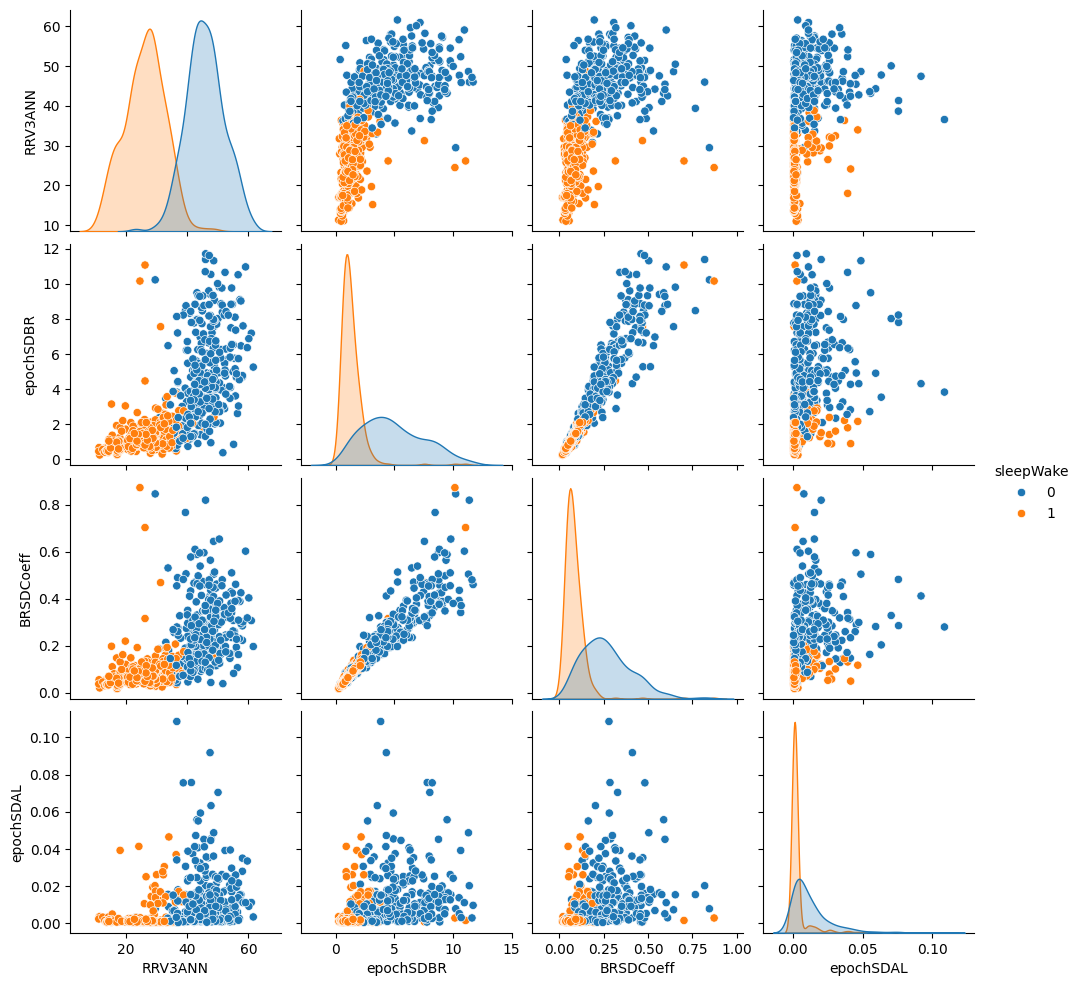

In [10]:
sns.pairplot(labelled_df, hue='sleepWake')
plt.show()

In [13]:
# Feature selection
selector = SelectKBest(score_func=f_classif, k=4)
selector.fit_transform(labelled_df, labelled_df['sleepWake'])
selector.get_support(indices=True)
l = [4]
print("Importance of features:")
for i in range(2, 6):
    selector = SelectKBest(score_func=f_classif, k=i)
    selector.fit_transform(labelled_df, labelled_df['sleepWake'])
    l_new = selector.get_support(indices=True)
    print([labelled_df.columns[i] for i in l_new if i not in l][0])
    l = l_new

Importance of features:
RRV3ANN
epochSDBR
BRSDCoeff
epochSDAL


In [180]:
labelled_df['combined_feature'] = unsupervised(labelled_df[['epochSDBR', 'BRSDCoeff', 'epochSDAL']], 'PCA')
labelled_df

RRV3ANN  epochSDBR  BRSDCoeff  epochSDAL  sleepWake  combined_feature
0    52.355000  10.651185   0.340838   0.039191          0          3.578592
1    48.396667   4.430392   0.307174   0.002006          0          0.690083
2    46.363333   4.914123   0.288295   0.002085          0          0.725658
3    44.310000   1.954584   0.112063   0.002277          0         -0.743011
4    41.690000   3.403552   0.244972   0.005739          0          0.299986
..         ...        ...        ...        ...        ...               ...
601  26.911667   1.092085   0.068437   0.000972          1         -1.183281
602  26.470000   1.419141   0.083256   0.002246          1         -0.997508
603  23.960000   1.423196   0.090126   0.001162          1         -1.003198
604  23.520000   1.035010   0.063481   0.000742          1         -1.226316
605  22.660000   1.469895   0.092072   0.002212          1         -0.948043

[606 rows x 6 columns]

### Unsupervised Learning: K-means clustering

Accuracy: 90.10%
Confusion Matrix:
[[248  54]
 [  6 298]]


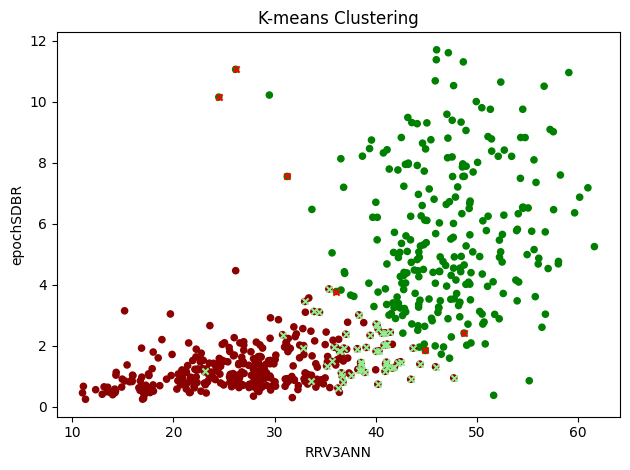

In [12]:
labelled_df['kmeans'] = unsupervised(labelled_df[['RRV3ANN', 'epochSDBR']], 'kmeans')

# Adjust based on your understanding of which cluster corresponds to sleep or awake
# labelled_df['kmeans'] = labelled_df['kmeans'].map({0: 1, 1: 0})
find_accuracy(labelled_df['kmeans'], labelled_df['sleepWake'])

plot_clustering(labelled_df, 'kmeans', 'sleepWake', 'RRV3ANN', 'epochSDBR', 'K-means Clustering')

### Unsupervised Learning: Expectation-Maximization (EM)

Accuracy: 91.254%
Confusion Matrix:
[[260  42]
 [ 11 293]]


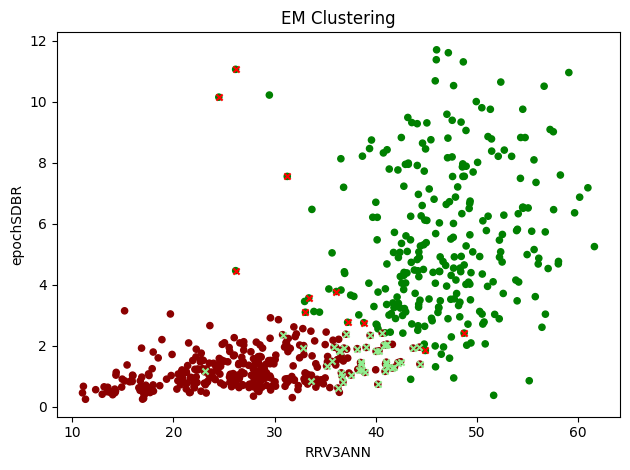

In [29]:
labelled_df['EM_Cluster'] = unsupervised(labelled_df[['RRV3ANN', 'epochSDBR']], 'EM_Cluster')

# Adjust based on your understanding of which cluster corresponds to sleep or awake
# labelled_df['EM_Cluster'] = labelled_df['EM_Cluster'].map({0: 1, 1: 0})
accuracy(labelled_df['EM_Cluster'], labelled_df['sleepWake'])

plot_clustering(labelled_df, 'EM_Cluster', 'sleepWake', 'RRV3ANN', 'epochSDBR', 'EM Clustering')

### Supervised Leaning: SVM

In [172]:
# SVM linear (Support Vector Machine)
features = ['RRV3ANN', 'epochSDBR', 'BRSDCoeff', 'epochSDAL']
X_train, X_test, y_train, y_test = split_sets(labelled_df, features, 'sleepWake')
model = supervised(X_train, y_train, 'svm_linear') #, [0.129]
y_pred = model.predict(X_test)
find_accuracy(y_pred, y_test)

Accuracy: 95.08%
Confusion Matrix:
[[54  4]
 [ 2 62]]


In [157]:
# SVM rbf (Support Vector Machine - Radial Basis Function)
X_train, X_test, y_train, y_test = split_sets(labelled_df, features, 'sleepWake')
model = supervised(X_train, y_train, 'svm_rbf') #, [1.668, 0.022]
y_pred = model.predict(X_test)
find_accuracy(y_pred, y_test)

Accuracy: 93.44%
Confusion Matrix:
[[51  4]
 [ 4 63]]


In [213]:
# Hyperparameter tuning
param_grid = {'C': np.arange(0.1, 0.3, 0.05), 
              'kernel': ['linear']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
X_train, X_test, y_train, y_test = split_sets(labelled_df, features, 'sleepWake')
grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.938 total time=   0.0s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.969 total time=   0.0s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.948 total time=   0.0s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.918 total time=   0.0s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.979 total time=   0.0s
[CV 1/5] END C=0.15000000000000002, kernel=linear;, score=0.938 total time=   0.0s
[CV 2/5] END C=0.15000000000000002, kernel=linear;, score=0.969 total time=   0.0s
[CV 3/5] END C=0.15000000000000002, kernel=linear;, score=0.959 total time=   0.0s
[CV 4/5] END C=0.15000000000000002, kernel=linear;, score=0.907 total time=   0.0s
[CV 5/5] END C=0.15000000000000002, kernel=linear;, score=0.979 total time=   0.0s
[CV 1/5] END C=0.20000000000000004, kernel=linear;, score=0.938 total time=   0.0s
[CV 2/5] END C=0.20000000000000004, k

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([0.1 , 0.15, 0.2 , 0.25]),
                         'kernel': ['linear']},
             verbose=3)

In [214]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 0.15000000000000002, 'kernel': 'linear'}
SVC(C=0.15000000000000002, kernel='linear')


In [208]:
# Hyperparameter tuning
param_grid = {'C': np.arange(0.8, 2, 0.1),  
              'gamma': np.arange(0.01, 0.03, 0.001), 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
X_train, X_test, y_train, y_test = split_sets(labelled_df, features, 'sleepWake')
grid.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END .....C=0.8, gamma=0.01, kernel=rbf;, score=0.959 total time=   0.0s
[CV 2/5] END .....C=0.8, gamma=0.01, kernel=rbf;, score=0.959 total time=   0.0s
[CV 3/5] END .....C=0.8, gamma=0.01, kernel=rbf;, score=0.948 total time=   0.0s
[CV 4/5] END .....C=0.8, gamma=0.01, kernel=rbf;, score=0.907 total time=   0.0s
[CV 5/5] END .....C=0.8, gamma=0.01, kernel=rbf;, score=0.979 total time=   0.0s
[CV 1/5] END ....C=0.8, gamma=0.011, kernel=rbf;, score=0.959 total time=   0.0s
[CV 2/5] END ....C=0.8, gamma=0.011, kernel=rbf;, score=0.959 total time=   0.0s
[CV 3/5] END ....C=0.8, gamma=0.011, kernel=rbf;, score=0.948 total time=   0.0s
[CV 4/5] END ....C=0.8, gamma=0.011, kernel=rbf;, score=0.918 total time=   0.0s
[CV 5/5] END ....C=0.8, gamma=0.011, kernel=rbf;, score=0.979 total time=   0.0s
[CV 1/5] END C=0.8, gamma=0.011999999999999999, kernel=rbf;, score=0.959 total time=   0.0s
[CV 2/5] END C=0.8, gamma=0.011999

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         'gamma': array([0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029]),
                         'kernel': ['rbf']},
             verbose=3)

In [209]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 0.8, 'gamma': 0.011, 'kernel': 'rbf'}
SVC(C=0.8, gamma=0.011)


In [166]:
# SVM rbf (Support Vector Machine - Radial Basis Function)
X_train, X_test, y_train, y_test = split_sets(labelled_df, features, 'sleepWake')
y_pred = grid.best_estimator_.predict(X_test)
find_accuracy(y_pred, y_test)

Accuracy: 94.26%
Confusion Matrix:
[[51  4]
 [ 3 64]]


In [139]:
gs = [0.1, 0.2, 0.3, 0.4, 0.5]

for g in gs:
    svm_classifier = SVC(kernel='rbf', C=1.6, gamma=g, random_state=0)
    svm_classifier.fit(X_train, y_train)

    y_pred = svm_classifier.predict(X_test)
    final_df = labelled_df.join(pd.DataFrame({'Final': y_pred}, index=X_test.index)).dropna(subset=['Final'])
    accuracy = accuracy_score(final_df['sleepWake'], final_df['Final'])
    print(f'Accuracy for g={g}: {accuracy * 100:.2f}%')

Accuracy for g=0.1: 95.08%
Accuracy for g=0.2: 95.90%
Accuracy for g=0.3: 95.90%
Accuracy for g=0.4: 94.26%
Accuracy for g=0.5: 94.26%


### 10-fold cross-validation

In [167]:
def ten_fold(model, X_test, y_test):
    print(model)
    # Perform 10-fold cross-validation
    scores = cross_val_score(model, X_test, y_test, cv=10)
    
    # for i, score in enumerate(scores, 1):
    #     print(f'Fold {i}: Accuracy = {score * 100:.2f}%')
    # print(scores)
    
    # Print the average accuracy across all folds
    average_accuracy = np.mean(scores)
    print(f'Average Accuracy: {average_accuracy * 100:.2f}%')

In [251]:
X_train, X_test, y_train, y_test = split_sets(labelled_df, features, 'sleepWake')

# 10-fold: svm_linear
model = supervised(labelled_df[features], labelled_df['sleepWake'], 'svm_linear', [0.05])
ten_fold(model, X_test, y_test)
print()

# 10-fold: svm_rbf
model = supervised(labelled_df[features], labelled_df['sleepWake'], 'svm_rbf', [0.8, 0.011])
ten_fold(model, X_test, y_test)
print()

# 10-fold: random_forest
model = supervised(labelled_df[features], labelled_df['sleepWake'], 'random_forest')
ten_fold(model, X_test, y_test)
print()

# 10-fold: naive_bayes
model = supervised(labelled_df[features], labelled_df['sleepWake'], 'neural_networks')
ten_fold(model, X_test, y_test)

SVC(C=0.05, kernel='linear', random_state=42)
Average Accuracy: 93.40%

SVC(C=0.8, gamma=0.011, random_state=42)
Average Accuracy: 94.23%

RandomForestClassifier(random_state=42)
Average Accuracy: 94.29%

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(15,), random_state=42,
              solver='lbfgs')
Average Accuracy: 93.40%


### Leave-One-Out Cross-Validation

In [247]:
def loo(model_name, par=[]):
    X = labelled_df[features].to_numpy()
    y = labelled_df['sleepWake'].to_numpy()
    # create loocv procedure
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    # Lists to store the true labels and the predictions
    y_true, y_pred = [], []
    
    # Perform LOOCV
    for train_index, test_index in loo.split(labelled_df['sleepWake']):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = supervised(X_train, y_train, model_name, par)
        prediction = model.predict(X_test)
        
        y_true.append(y_test[0])
        y_pred.append(prediction[0])
    print(model)
    
    # Calculate and print the accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

In [256]:
# leave-one-out: svm_linear
loo('svm_linear')
print()

# leave-one-out: svm_rbf
loo('svm_rbf', [0.8, 0.011])
print()

SVC(kernel='linear', random_state=42)
Accuracy: 95.05%

SVC(C=0.8, gamma=0.011, random_state=42)
Accuracy: 94.55%



In [257]:
# leave-one-out: random_forest
# loo('random_forest')
# print()

# leave-one-out: neural_networks
loo('neural_networks')

RandomForestClassifier(random_state=42)
Accuracy: 95.71%

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(15,), random_state=42,
              solver='lbfgs')
Accuracy: 95.05%


### Simulate semi

In [226]:
labelled_df['kmeans'] = unsupervised(labelled_df[features], 'kmeans')
labelled_df['kmeans'] = labelled_df['kmeans'].map({0:1, 1:0})
labelled_df

RRV3ANN  epochSDBR  BRSDCoeff  epochSDAL  sleepWake  kmeans
0    52.355000  10.651185   0.340838   0.039191          0       0
1    48.396667   4.430392   0.307174   0.002006          0       0
2    46.363333   4.914123   0.288295   0.002085          0       0
3    44.310000   1.954584   0.112063   0.002277          0       1
4    41.690000   3.403552   0.244972   0.005739          0       0
..         ...        ...        ...        ...        ...     ...
601  26.911667   1.092085   0.068437   0.000972          1       1
602  26.470000   1.419141   0.083256   0.002246          1       1
603  23.960000   1.423196   0.090126   0.001162          1       1
604  23.520000   1.035010   0.063481   0.000742          1       1
605  22.660000   1.469895   0.092072   0.002212          1       1

[606 rows x 6 columns]

In [267]:
# Tested for accuracy
np.random.seed(0)
labelled_df['mask'] = np.random.rand(len(labelled_df)) < 0.5  # Randomly generate a True/False mask
labelled_df['concat'] = labelled_df.sleepWake if labelled_df.mask else labelled_df.kmeans

X_train, X_test, y_train, _ = split_sets(labelled_df, features, 'concat')
_, _, _, y_test = split_sets(labelled_df, features, 'sleepWake')

# 10-fold: semi
model = supervised(labelled_df[features], labelled_df['concat'], 'svm_rbf', [0.8, 0.011])
ten_fold(model, X_test, y_test)
print()

# leave-one-out: semi
X = labelled_df[features].to_numpy()
y = labelled_df['concat'].to_numpy()
T = labelled_df['sleepWake'].to_numpy()
# create loocv procedure
loo = LeaveOneOut()
loo.get_n_splits(X)
# Lists to store the true labels and the predictions
y_true, y_pred = [], []

# Perform LOOCV
for train_index, test_index in loo.split(labelled_df['sleepWake']):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], T[test_index]
    
    model = supervised(X_train, y_train, 'svm_rbf', [0.8, 0.011])
    prediction = model.predict(X_test)
    
    y_true.append(y_test[0])
    y_pred.append(prediction[0])
print(model)

# Calculate and print the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

SVC(C=0.8, gamma=0.011, random_state=42)
Average Accuracy: 94.23%

SVC(C=0.8, gamma=0.011, random_state=42)
Accuracy: 94.55%


In [270]:
labelled_df['EM_Cluster'] = unsupervised(labelled_df[features], 'EM_Cluster')
labelled_df['EM_Cluster'] = labelled_df['EM_Cluster'].map({0:1, 1:0})
labelled_df['mask'] = np.random.rand(len(labelled_df)) < 0.5  # Randomly generate a True/False mask
labelled_df['concat'] = labelled_df.sleepWake if labelled_df.mask else labelled_df.kmeans

# Tested for accuracy
X_train, X_test, y_train, _ = split_sets(labelled_df, features, 'concat')
_, _, _, y_test = split_sets(labelled_df, features, 'sleepWake')

# 10-fold: semi
model = supervised(labelled_df[features], labelled_df['EM_Cluster'], 'svm_rbf', [0.8, 0.011])
ten_fold(model, X_test, y_test)
print()

# leave-one-out: semi
X = labelled_df[features].to_numpy()
y = labelled_df['EM_Cluster'].to_numpy()
T = labelled_df['sleepWake'].to_numpy()
# create loocv procedure
loo = LeaveOneOut()
loo.get_n_splits(X)
# Lists to store the true labels and the predictions
y_true, y_pred = [], []

# Perform LOOCV
for train_index, test_index in loo.split(labelled_df['sleepWake']):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], T[test_index]
    
    model = supervised(X_train, y_train, 'svm_rbf', [0.8, 0.011])
    prediction = model.predict(X_test)
    
    y_true.append(y_test[0])
    y_pred.append(prediction[0])
print(model)

# Calculate and print the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

SVC(C=0.8, gamma=0.011, random_state=42)
Average Accuracy: 94.23%

SVC(C=0.8, gamma=0.011, random_state=42)
Accuracy: 94.06%


Int64Index([  0,  12,  28,  39,  56,  73,  91,  99, 115, 131, 147, 155, 171,
            183, 199, 217, 233, 246, 262, 277, 290, 306, 322, 346, 362, 378,
            394, 410, 426, 445, 461, 479, 495, 517, 533, 547, 563, 590],
           dtype='int64')


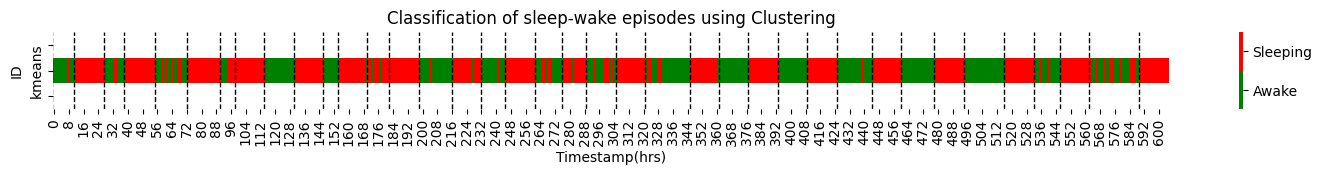

In [193]:
heat_map = labelled_df[['kmeans']].copy().T
empty_row = pd.DataFrame(index=[""])
heat_map = pd.concat([empty_row, heat_map, empty_row])
fig, ax = plt.subplots(figsize=(18, 1))
sns.heatmap(heat_map, vmin = 0, vmax = 1, cmap=sns.color_palette(["green", "red"]))
ax.set_ylabel("ID")
ax.set_xlabel("Timestamp(hrs)")
ax.set_title("Classification of sleep-wake episodes using Clustering")
plt.tight_layout()
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels(["Awake", "Sleeping"])

transitions = labelled_df['sleepWake'].diff().ne(0)
transition_points = labelled_df.index[transitions]
print(transition_points)
for point in transition_points:
    plt.axvline(x=point-0.5, color='black', linestyle='--', linewidth=1)
plt.show()

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Heatmap(
    z=heat_map,
    zmin=0,
    zmax=1,
    colorbar = dict(tickvals=[0.25, 0.75], tickmode="array", ticktext=["awake", "sleeping"]),
    colorscale=[[0.0, "green"],
                [1.0, "red"]],
    yaxis='y1'))

x_old = 0
for i, point in enumerate(transition_points):
    x = point-0.5
    fig.add_shape(type='line', x0=x, x1=x, y0=0, y1=2, line=dict(color='black', width=1, dash='dash'))
    if i % 2 == 1:
        fig.add_shape(type="rect", xref="x", yref="y", x0=x_old, y0=0, x1=x, y1=2, fillcolor="lightgreen", 
                      opacity=0.4, line_width=0, layer="below")
    else:
        x_old = x

fig.add_trace(go.Scatter(
    x=labelled_df.index,
    y=labelled_df['RRV3ANN'],
    line=dict(color="grey"),
    name="RRV3ANN",
    yaxis="y2"))
        
fig.add_trace(go.Scatter(
    x=labelled_df.index,
    y=labelled_df['epochSDBR'],
    line=dict(color="black"),
    name="epochSDBR",
    yaxis="y2"))

fig.update_layout(legend=dict(y=-0.2)) 

fig.show()

## Semi-supervised learning

In [220]:
def semisupervised(data):
    labelled_df = pd.read_csv("APCAPS_clean_training_data.csv")[:606]
    # Separate features and labels
    data = data.rename({'RRV3MA': 'RRV3ANN', 'BR_std': 'epochSDBR', 'BR_cov': 'BRSDCoeff', 'AL_std': 'epochSDAL'}, axis=1)

    # Perform unsupervised learning
    data['kmeans'] = unsupervised(data[['position', 'RRV3ANN']], 'kmeans')
    data = redirect(data, 'kmeans')

    # Split sets and concate with labelled data
    if len(data) < 500:
        p = 0.8
    else:
        p = 1 - 500 / len(data)
    print('p:', round(p, 4))
    X_train, X_test, y_train, y_test = split_sets(data, ['RRV3ANN', 'epochSDBR', 'BRSDCoeff', 'epochSDAL'], 'kmeans', p)
    X_train = pd.concat([X_train, labelled_df.drop('sleepWake', axis=1)])
    y_train = pd.concat([y_train, labelled_df['sleepWake']])

    model = supervised(X_train, y_train, 'svm_linear')
    return X_test.index, model.predict(X_test)

PRB006 has 54508 rows,
dropped 3397 rows with NA.
Redirected
p: 0.9902


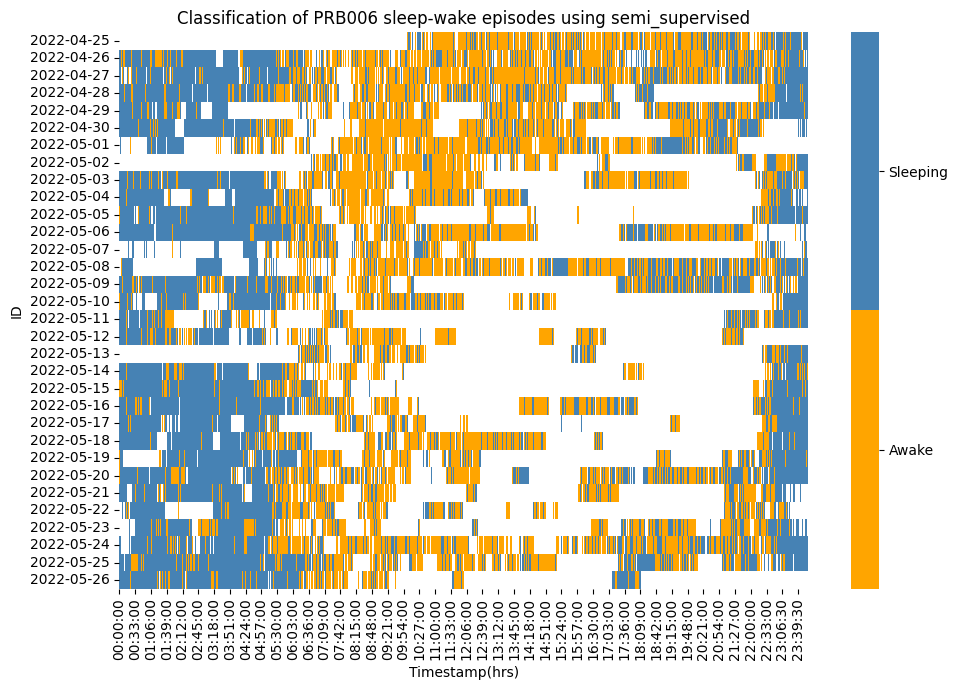

In [50]:
id = 'PRB006'
data = load_data_secondary(id)

index, y_pred = semisupervised(data)
final_df = data.join(pd.DataFrame({'semi_supervised': y_pred}, index=index)).dropna(subset=['semi_supervised'])
plot_predict_heatmap(final_df, 'semi_supervised', id) # , save="semi/"

PRB001 has 35508 rows,
dropped 3537 rows with NA.
p: 0.9844


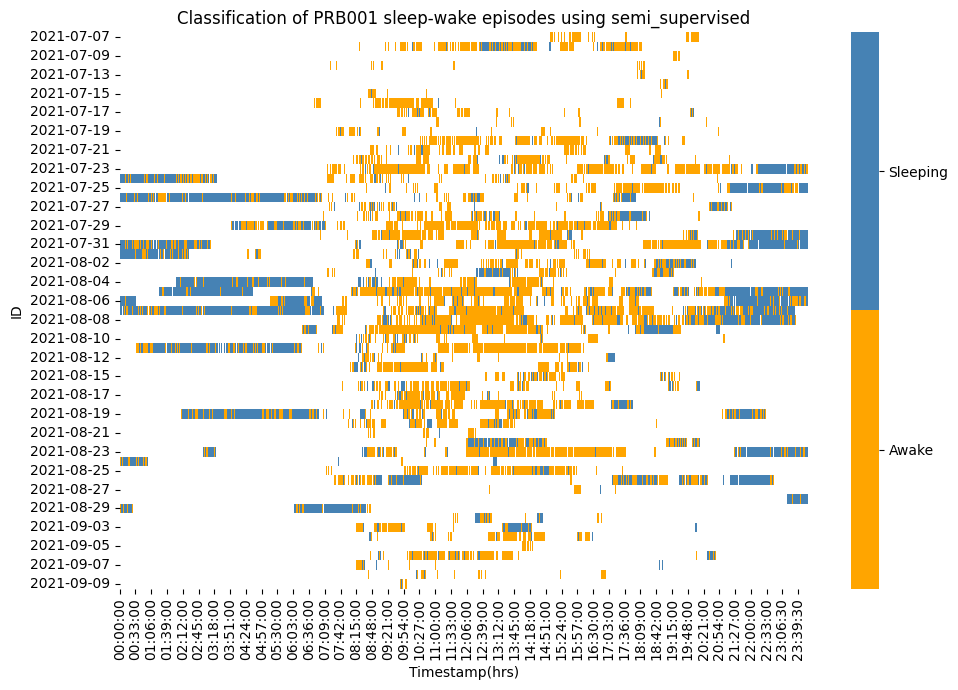

PRB003 has 83629 rows,
dropped 23693 rows with NA.
p: 0.9917


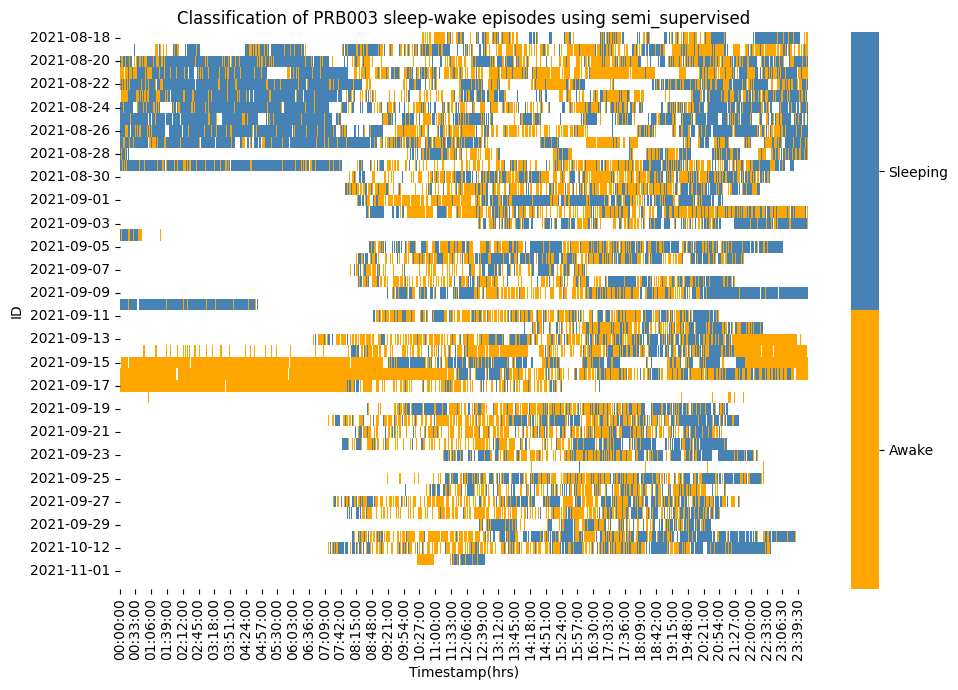

PRB004 has 5105 rows,
dropped 261 rows with NA.
Redirected
p: 0.8968


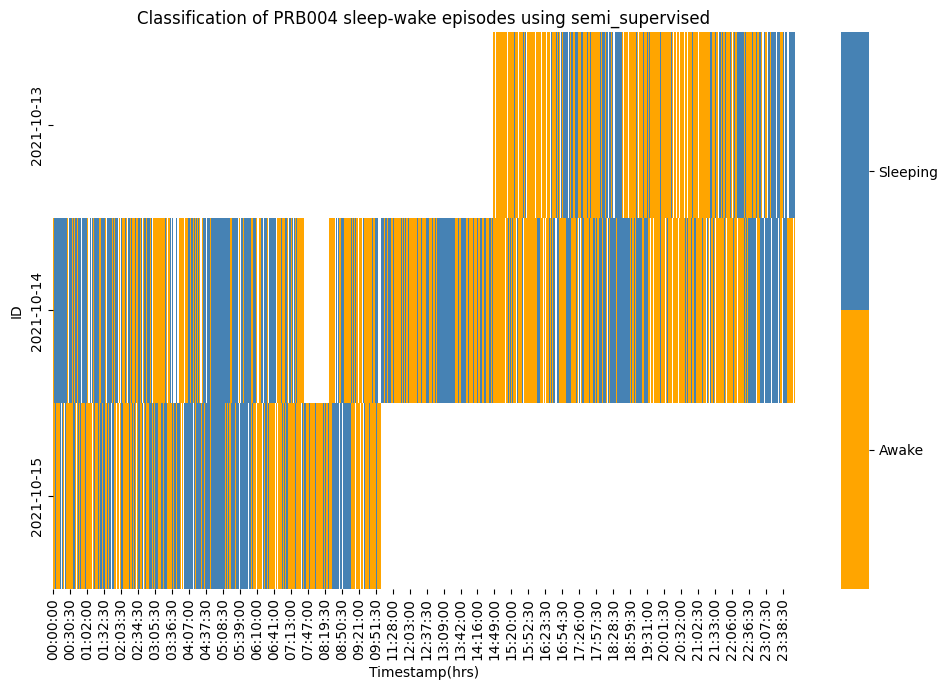

PRB005 has 76461 rows,
dropped 12476 rows with NA.
p: 0.9922


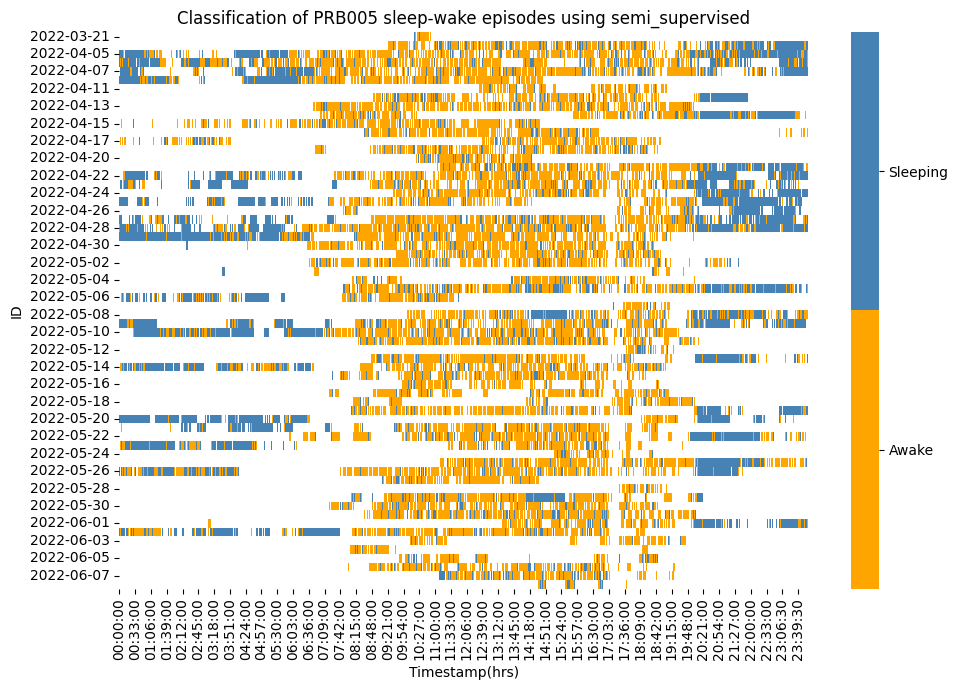

PRB006 has 54508 rows,
dropped 3397 rows with NA.
Redirected
p: 0.9902


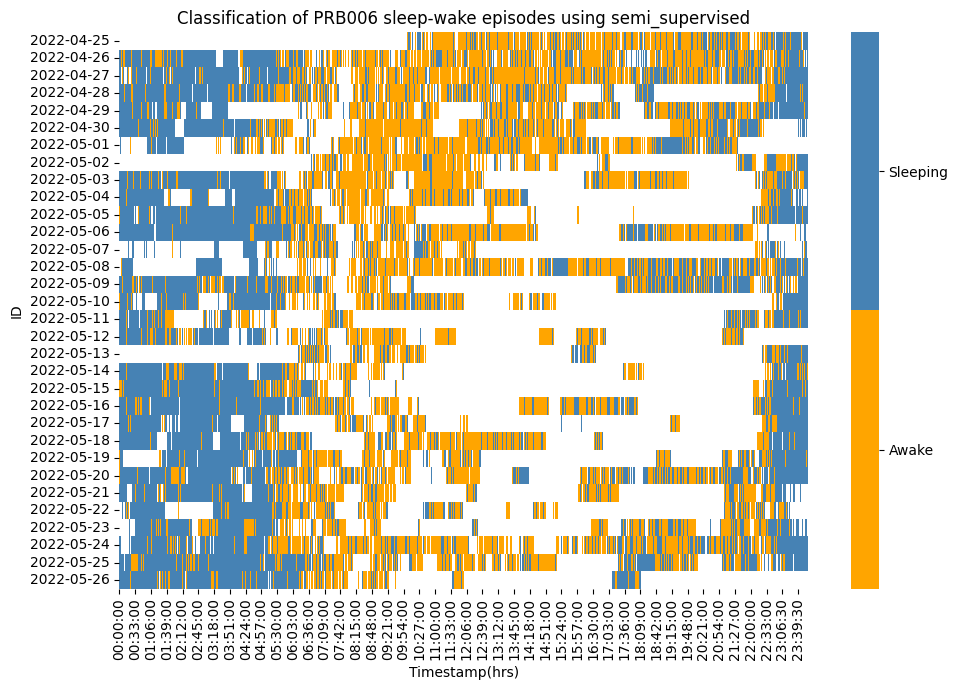

PRB007 has 66284 rows,
dropped 14440 rows with NA.
Redirected
p: 0.9904


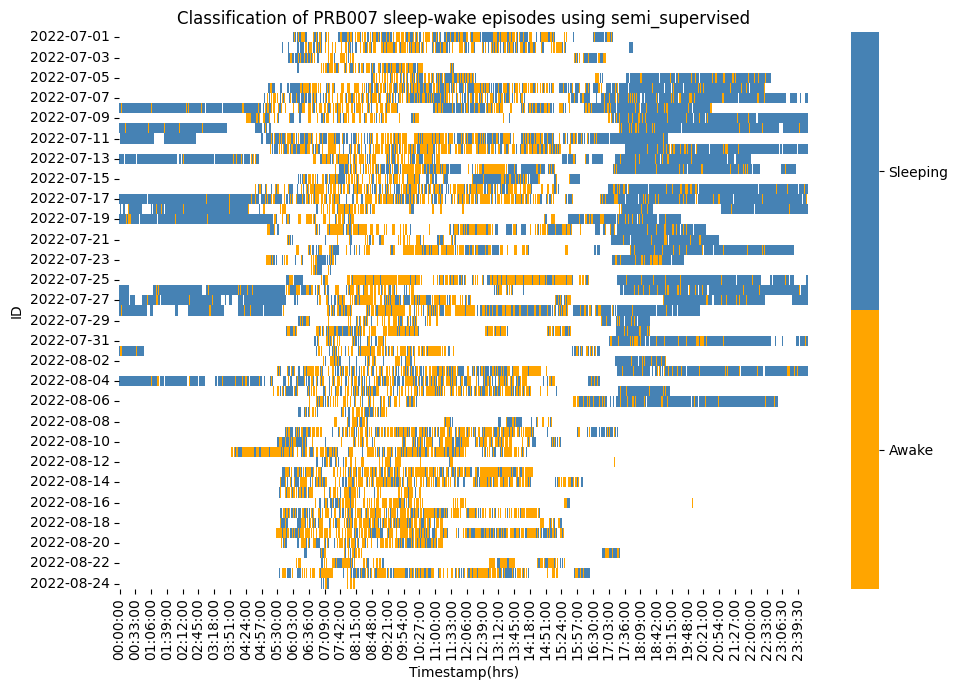

PRB102 has 130644 rows,
dropped 51540 rows with NA.
p: 0.9937


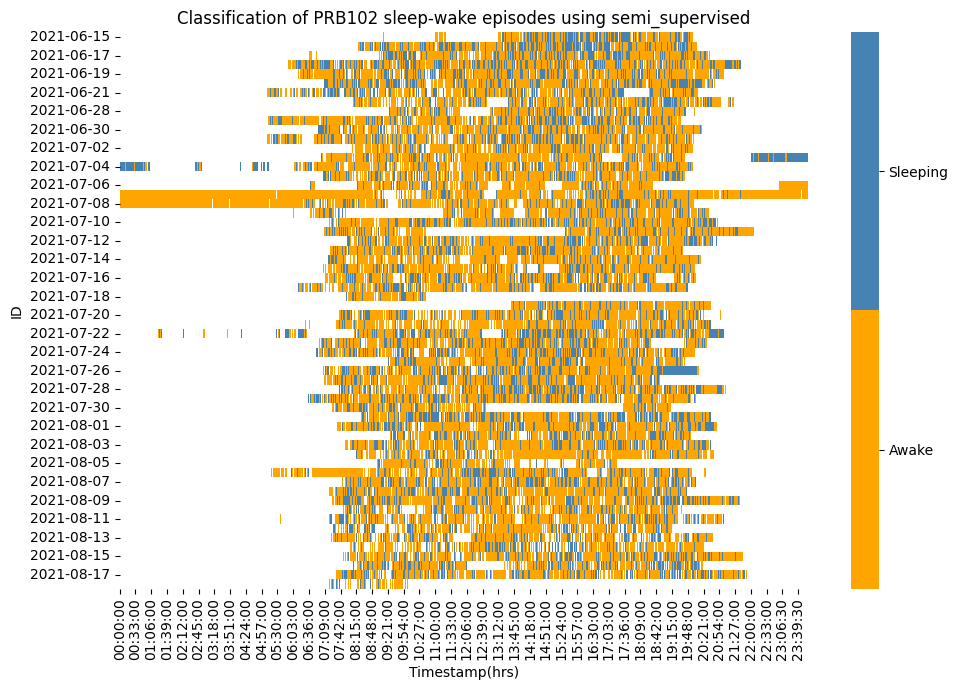

PRB103 has 89186 rows,
dropped 9843 rows with NA.
Redirected
p: 0.9937


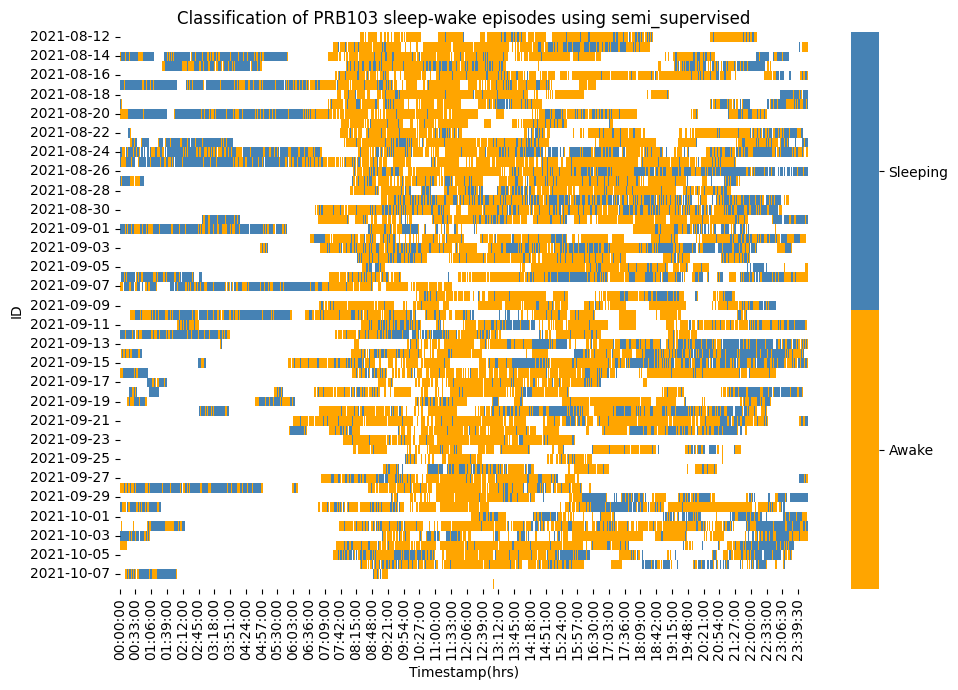

PRB104 has 102695 rows,
dropped 31334 rows with NA.
p: 0.993


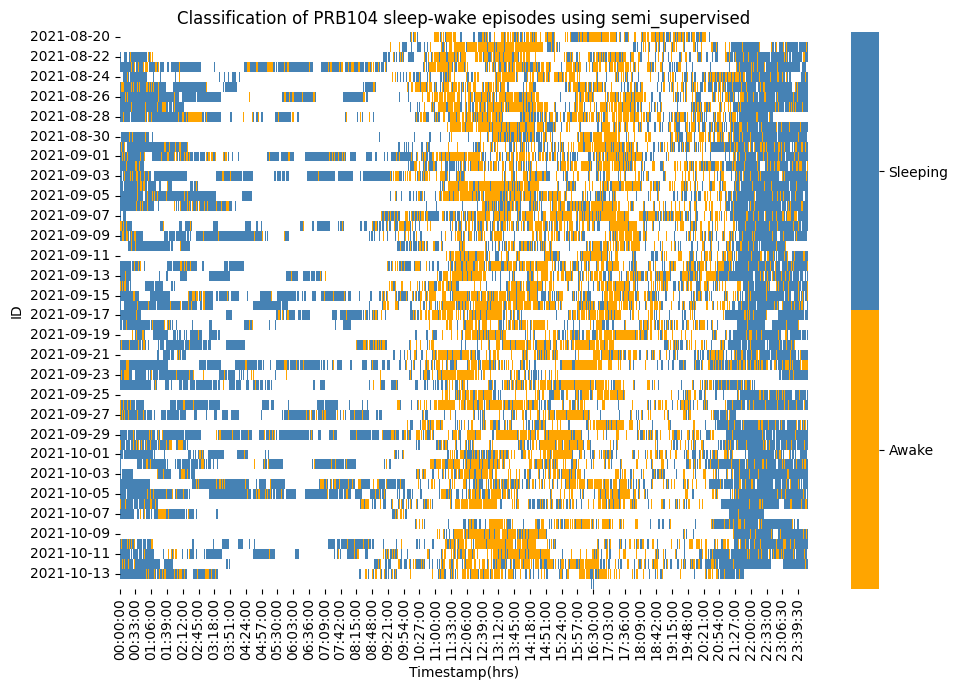

PRB105 has 124820 rows,
dropped 25450 rows with NA.
p: 0.995


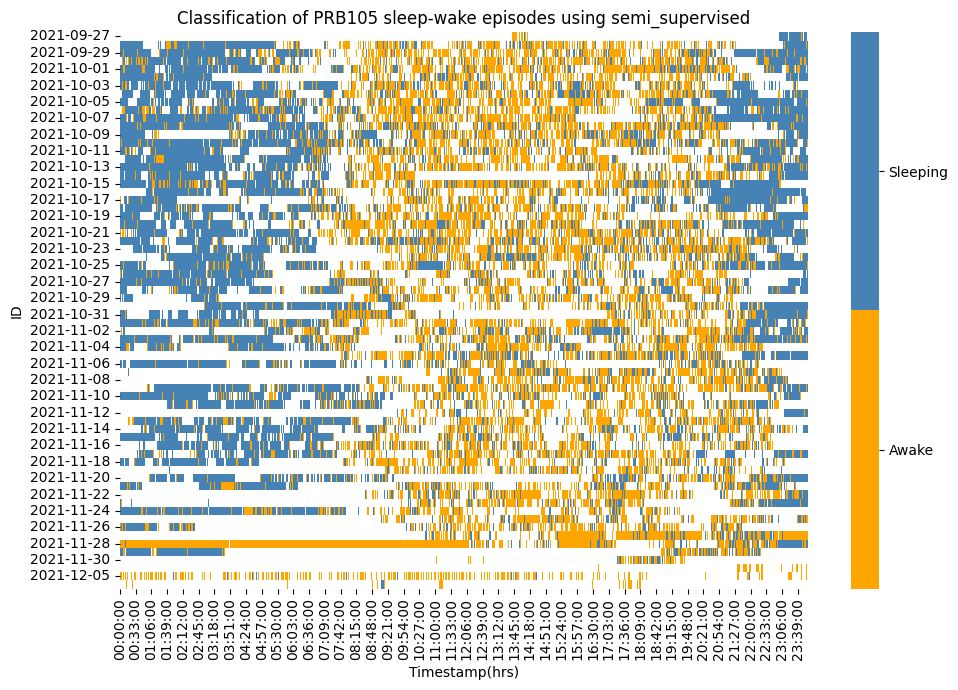

PRB106 has 480 rows,
dropped 103 rows with NA.
p: 0.8


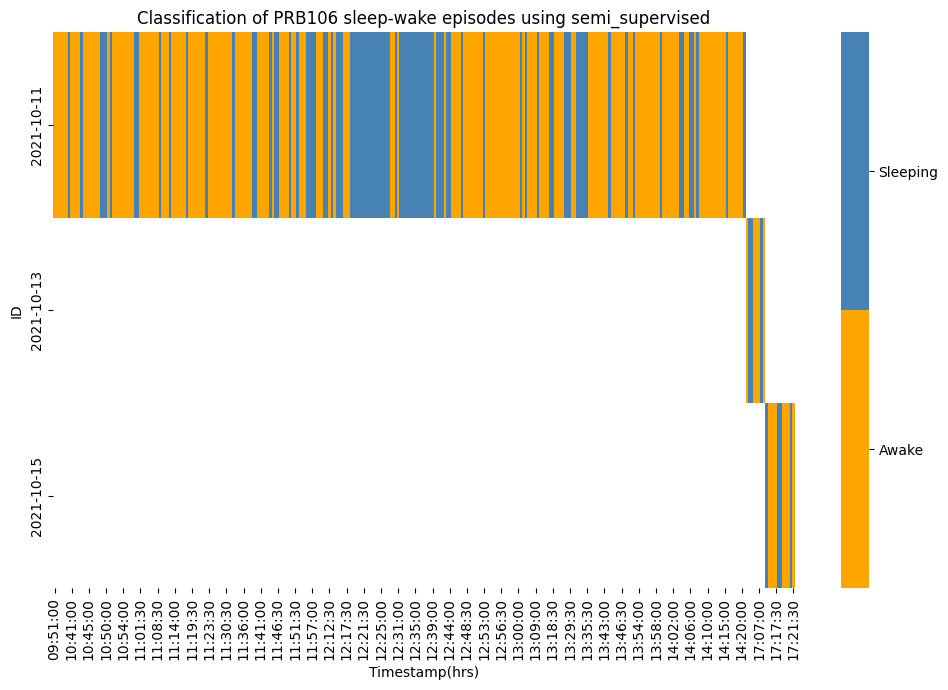

PRB107 has 52851 rows,
dropped 10832 rows with NA.
Redirected
p: 0.9881


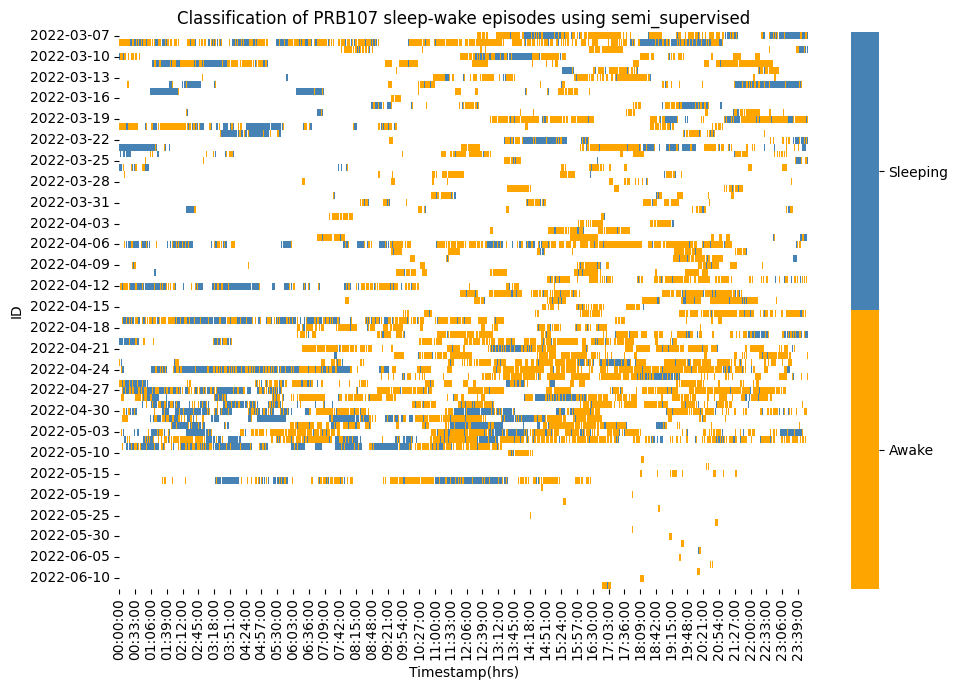

PRB108 has 91692 rows,
dropped 14708 rows with NA.
p: 0.9935


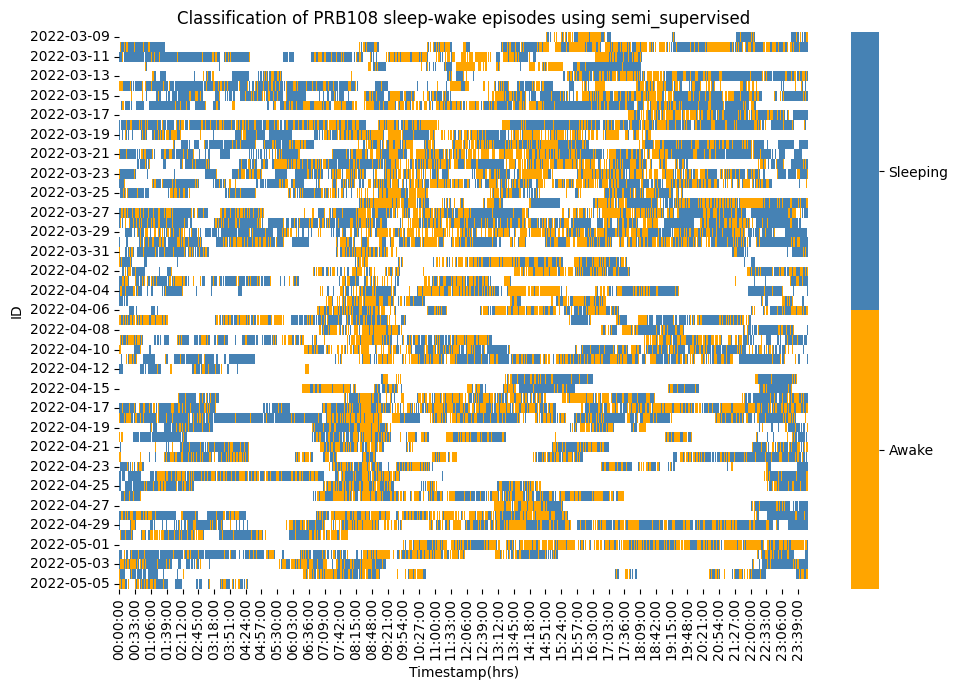

PRB109 has 26878 rows,
dropped 7457 rows with NA.
Redirected
p: 0.9743


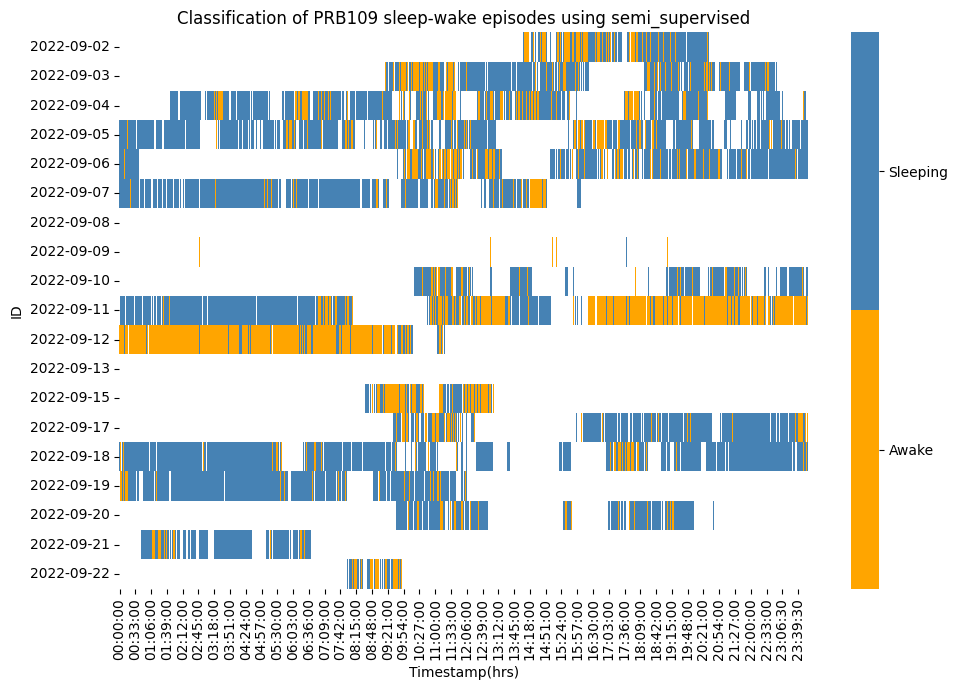

PRB201 has 62543 rows,
dropped 2401 rows with NA.
p: 0.9917


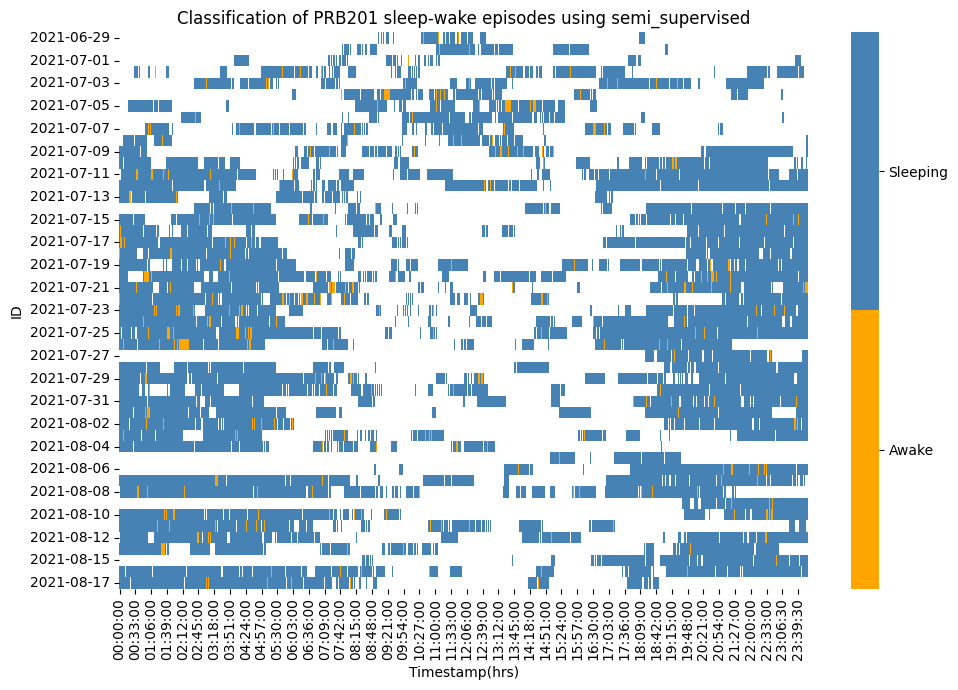

PRB202 has 62458 rows,
dropped 6415 rows with NA.
p: 0.9911


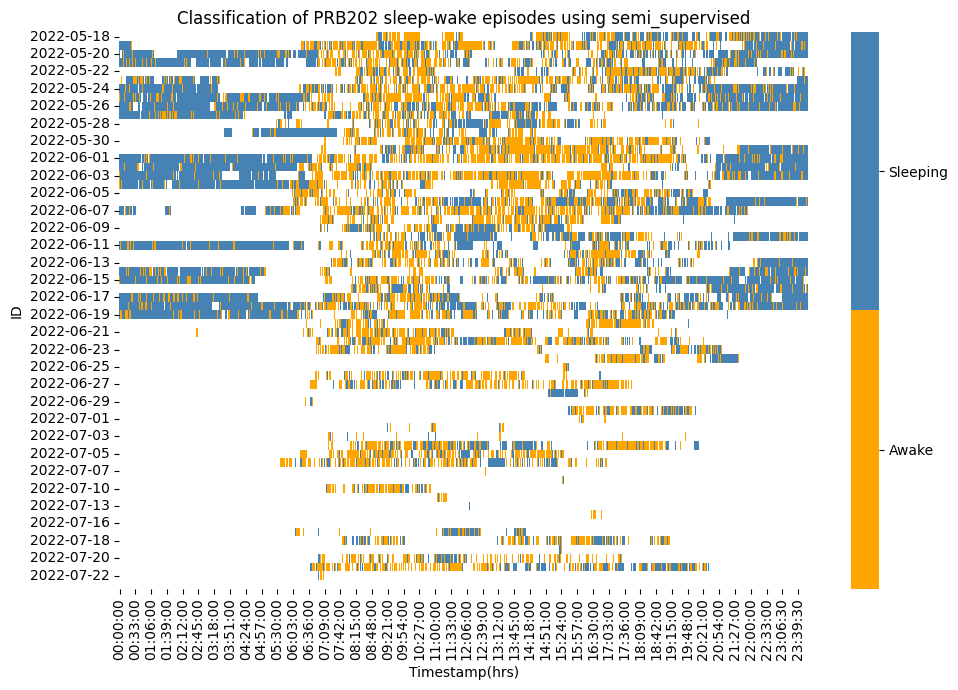

PRB203 has 146402 rows,
dropped 8440 rows with NA.
p: 0.9964


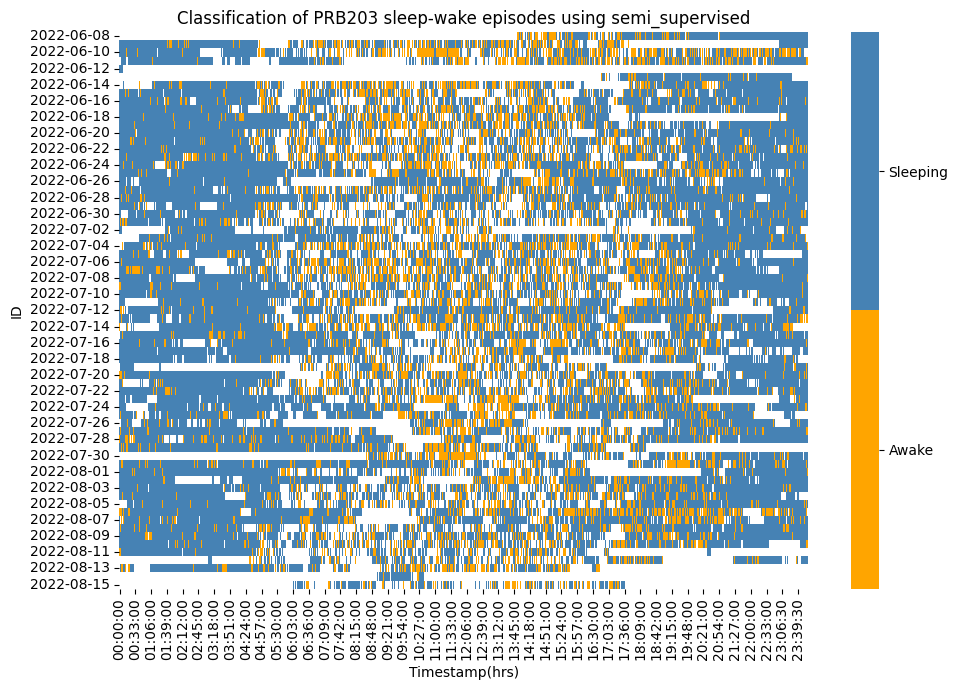

PRX018 has 147009 rows,
dropped 34018 rows with NA.
Redirected
p: 0.9956


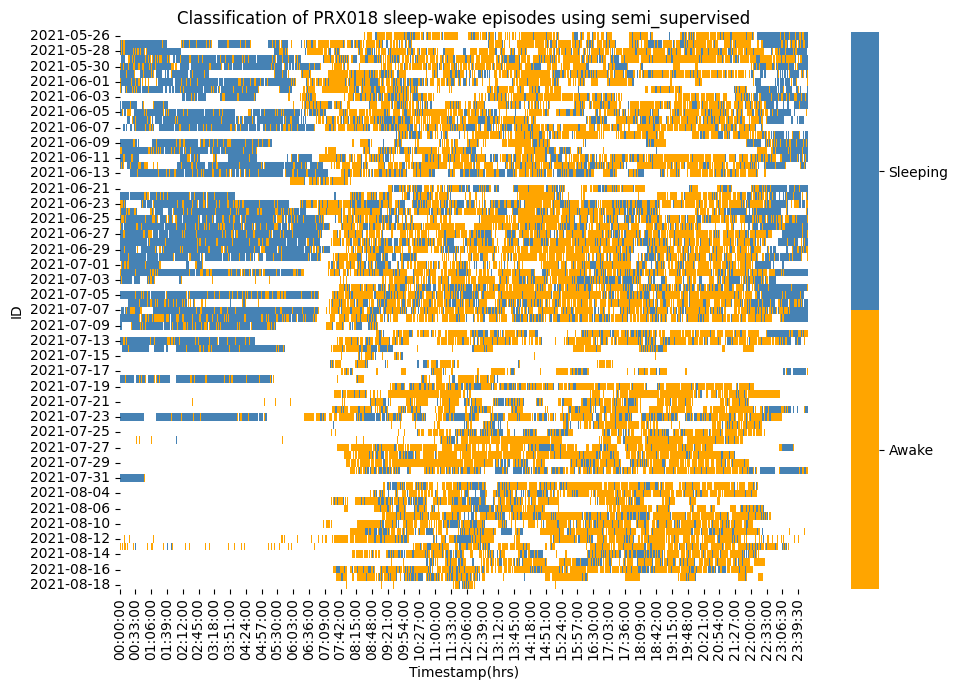

PRX900 has 103352 rows,
dropped 16158 rows with NA.
p: 0.9943


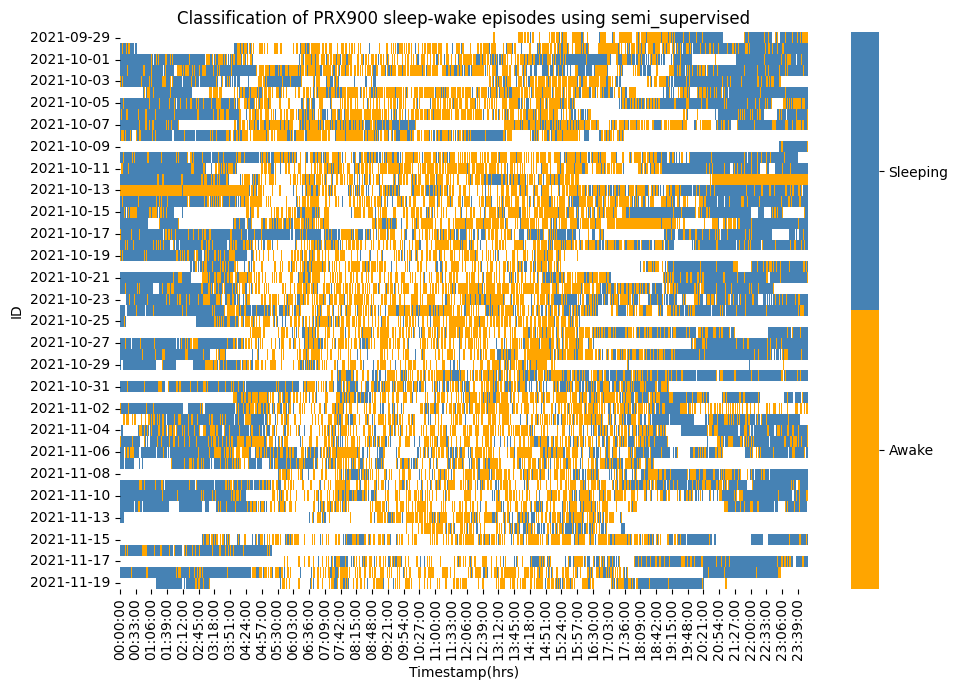

In [20]:
# Run semi-supervised on all subjects
for id in ids:
    # Run semi-supervised learning
    df = load_data_secondary(id)
    index, y_pred = semisupervised(df)
    df = df.join(pd.DataFrame({'semi_supervised': y_pred}, index=index)).dropna(subset=['semi_supervised'])
    plot_predict_heatmap(df, 'semi_supervised', id, save=True)
    
    df["date"] = df.index.strftime('%Y-%m-%d')
    df = df.drop(['position'], axis=1)
    df = df.rename({'semi_supervised': 'isSleep'}, axis=1)
    df.to_csv(f"results/NHS/SleepAwake/{id}_semi.csv")

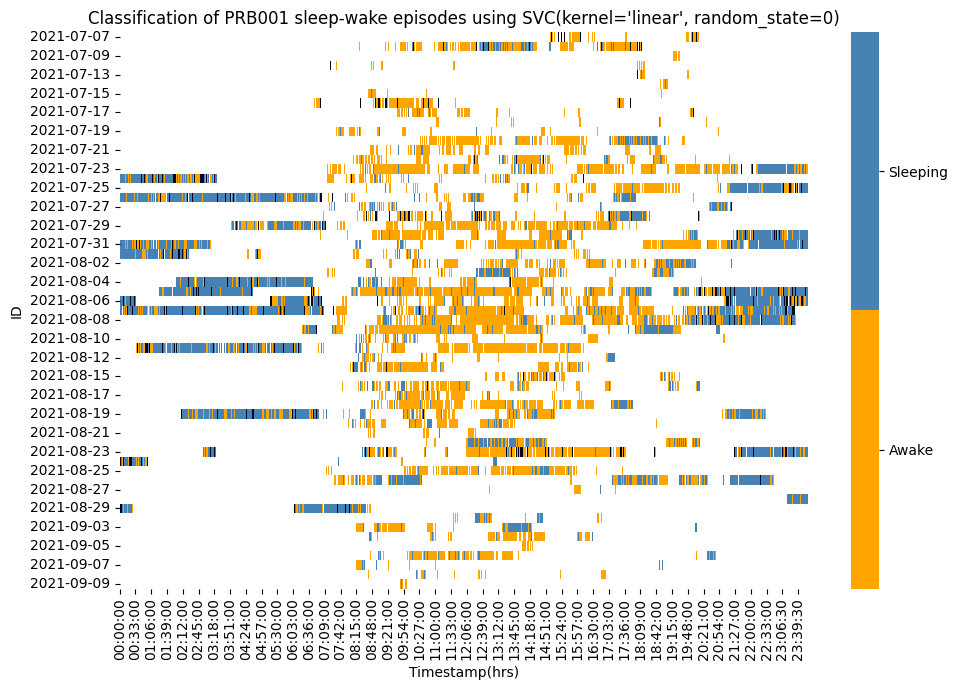

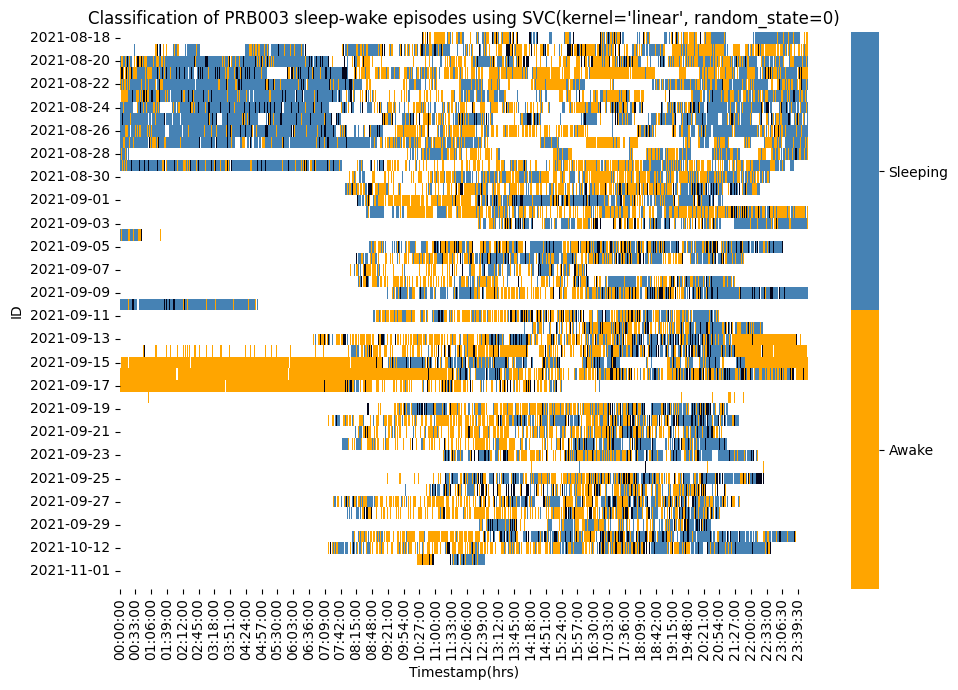

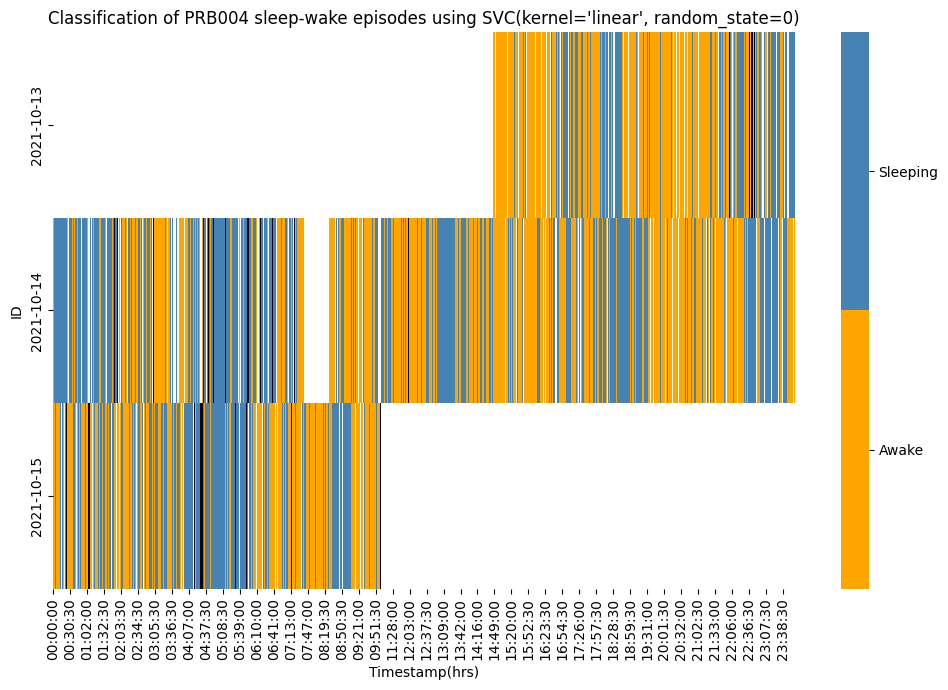

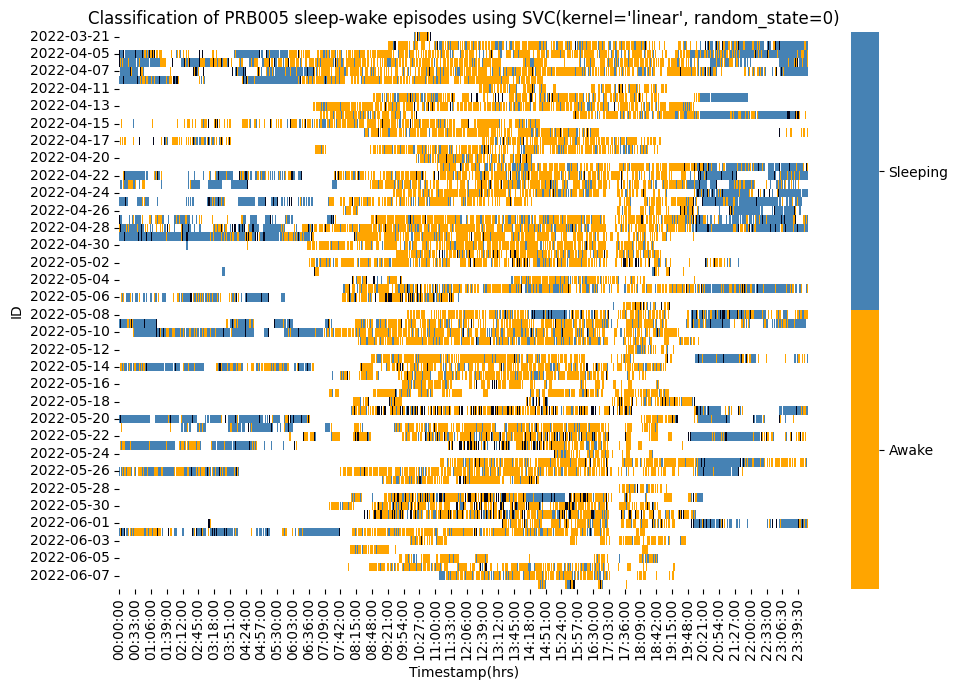

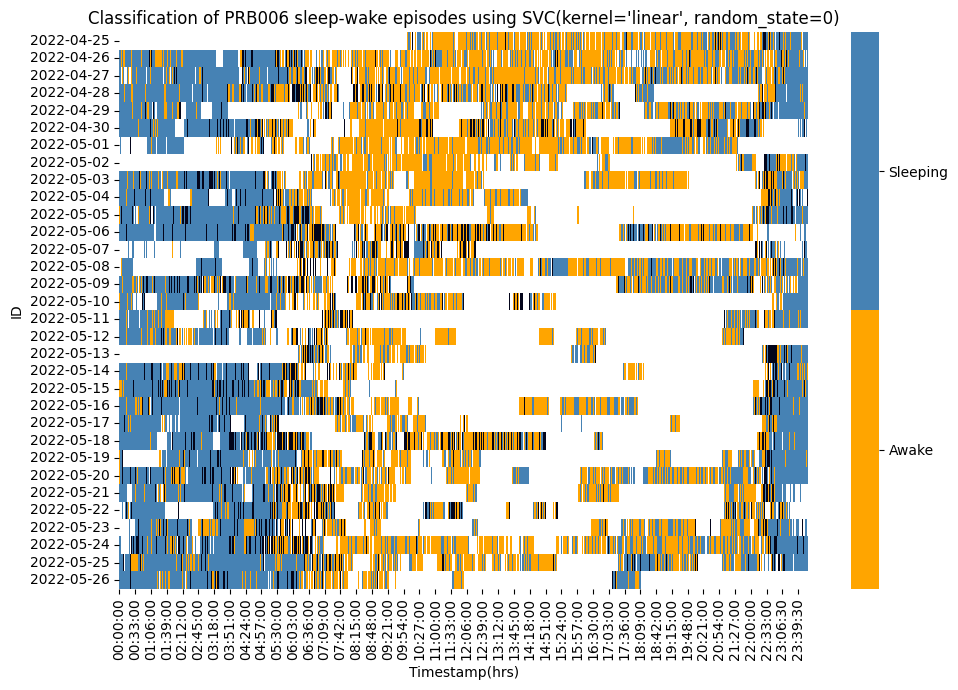

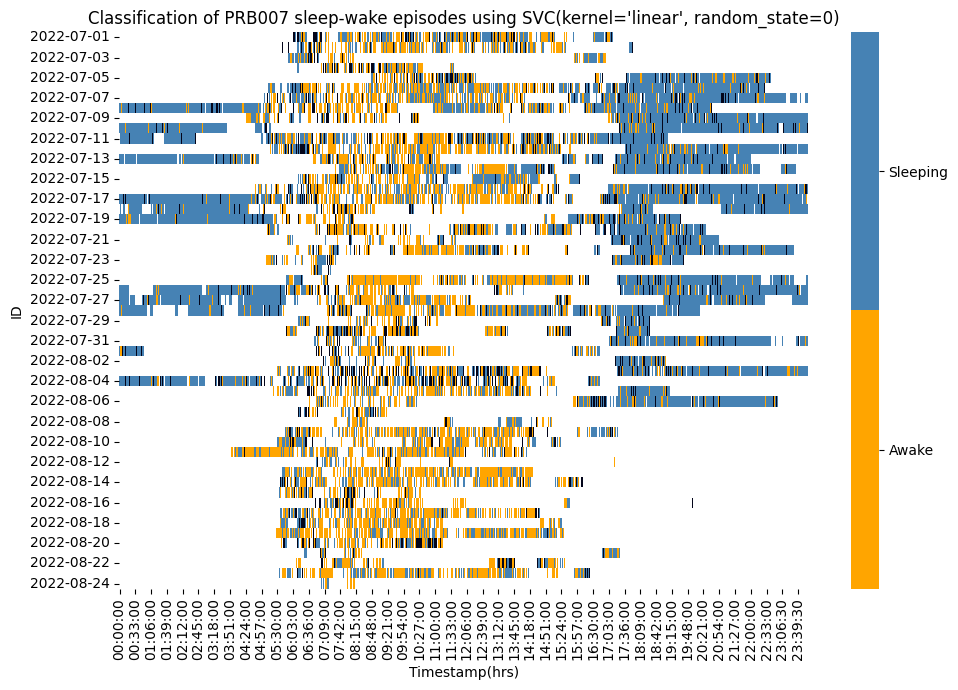

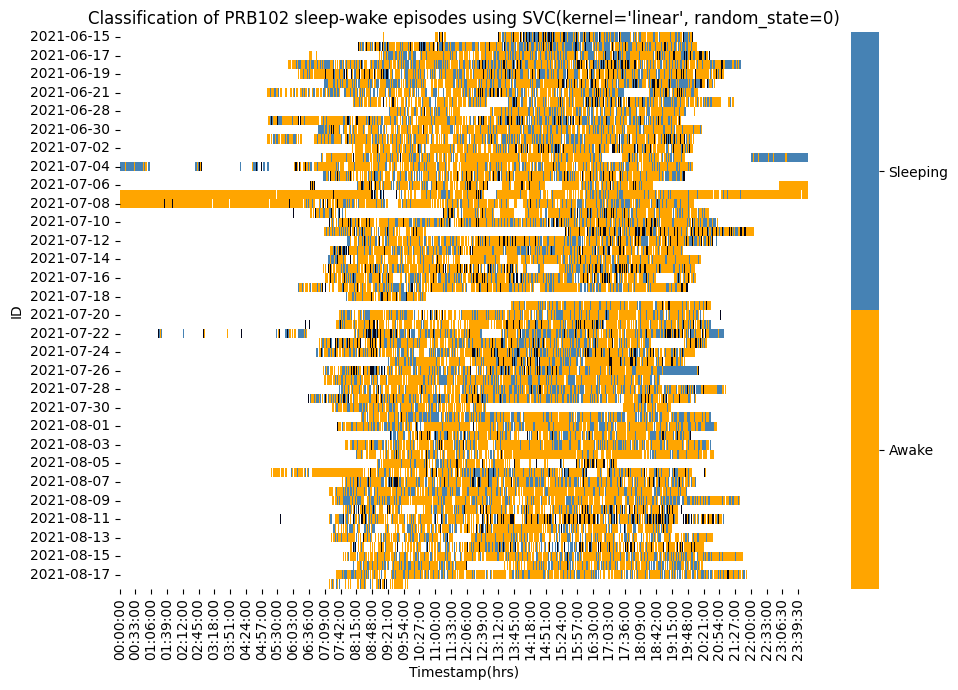

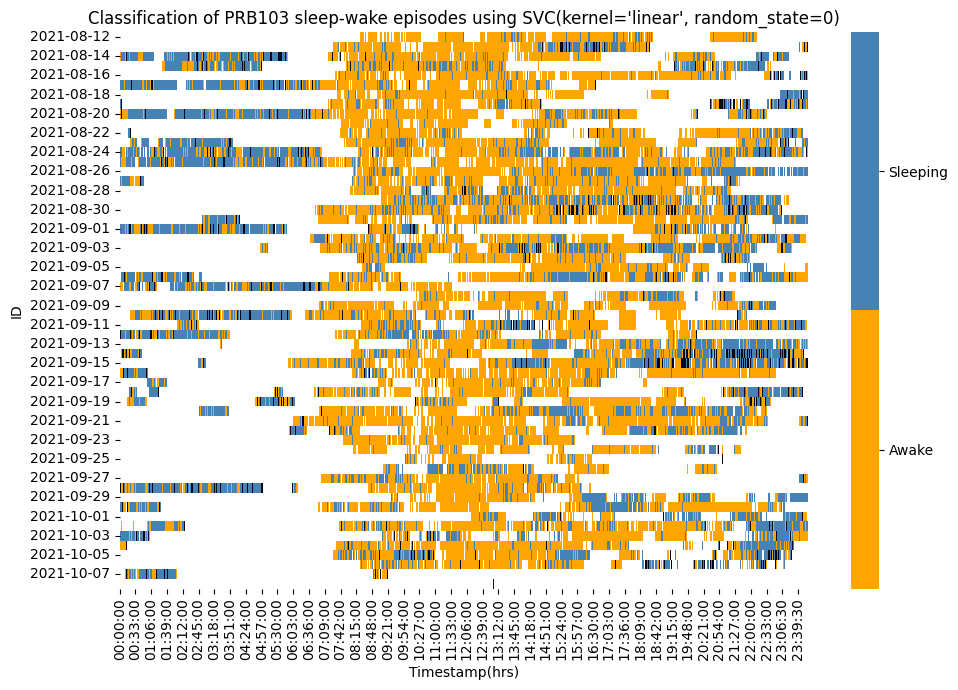

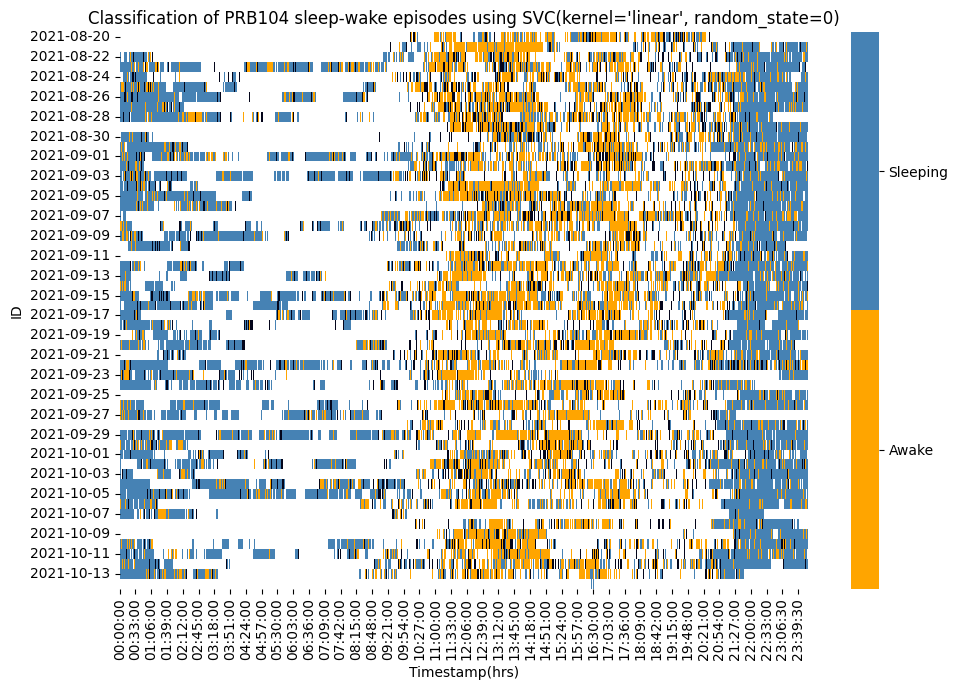

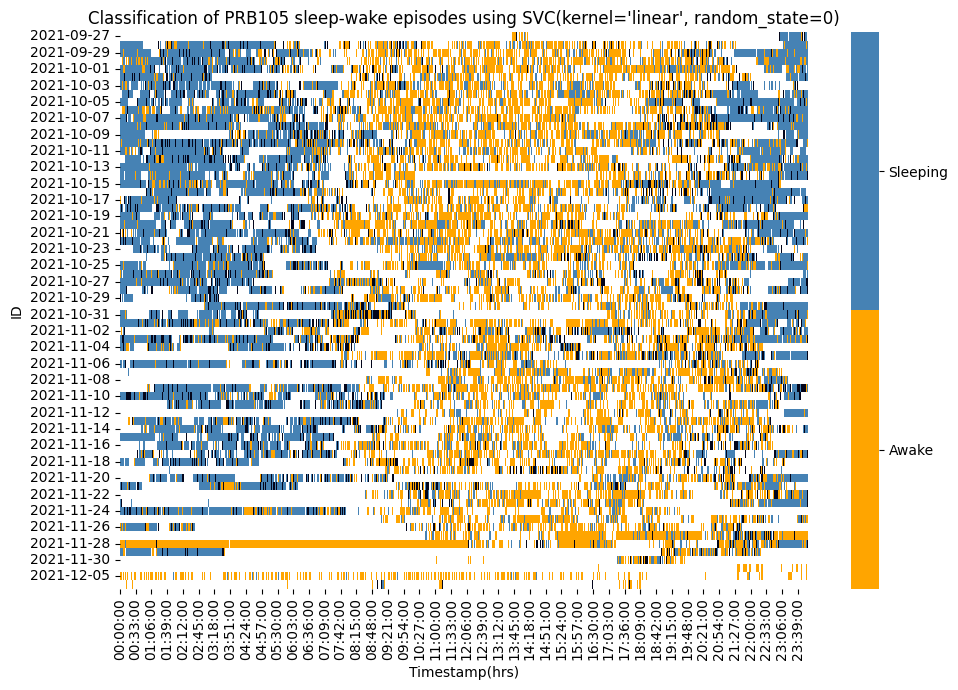

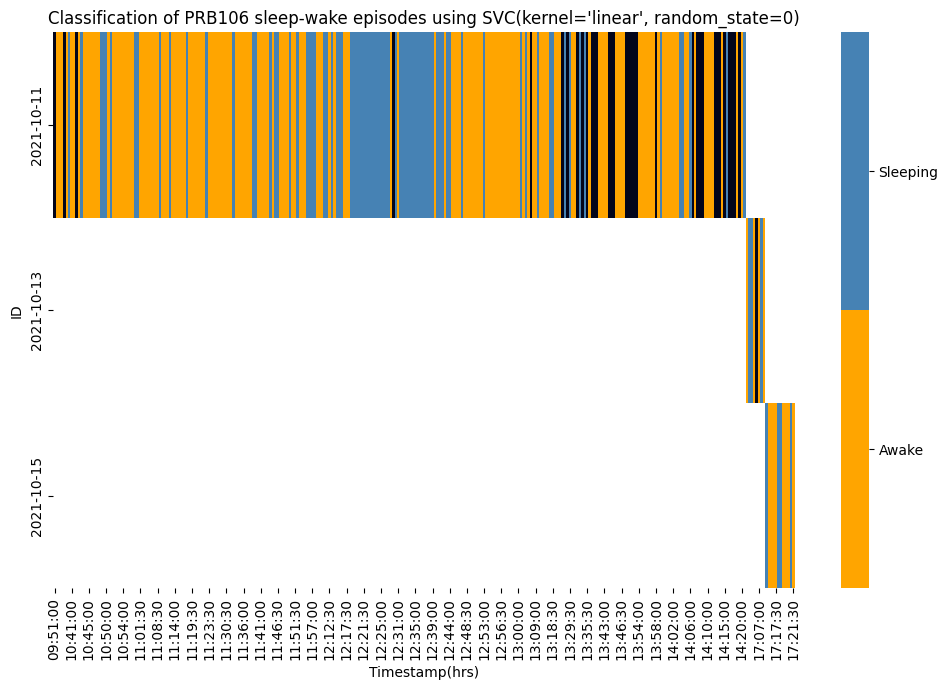

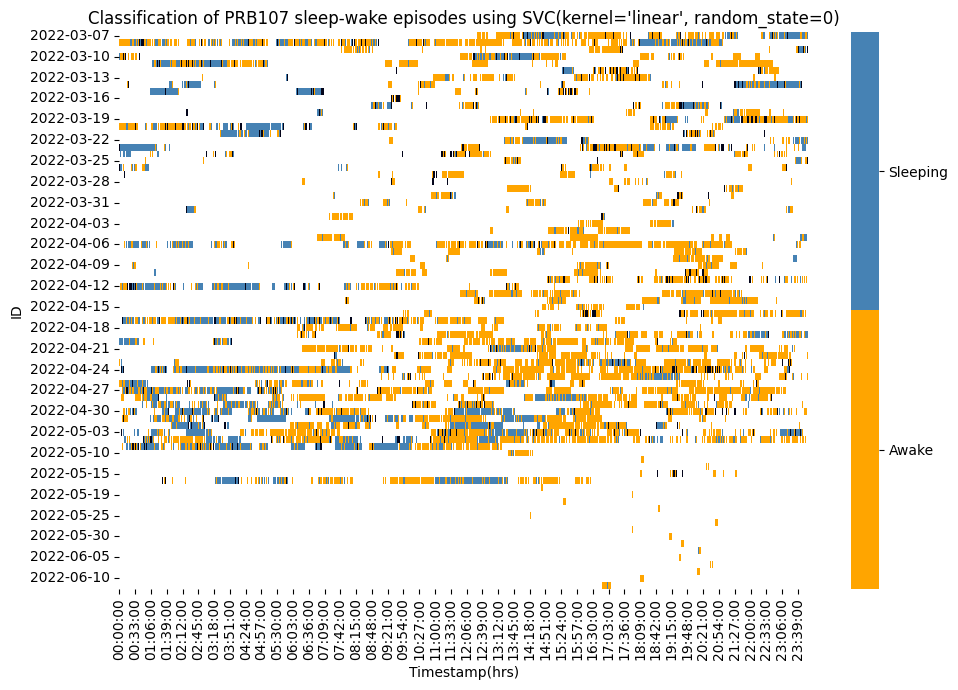

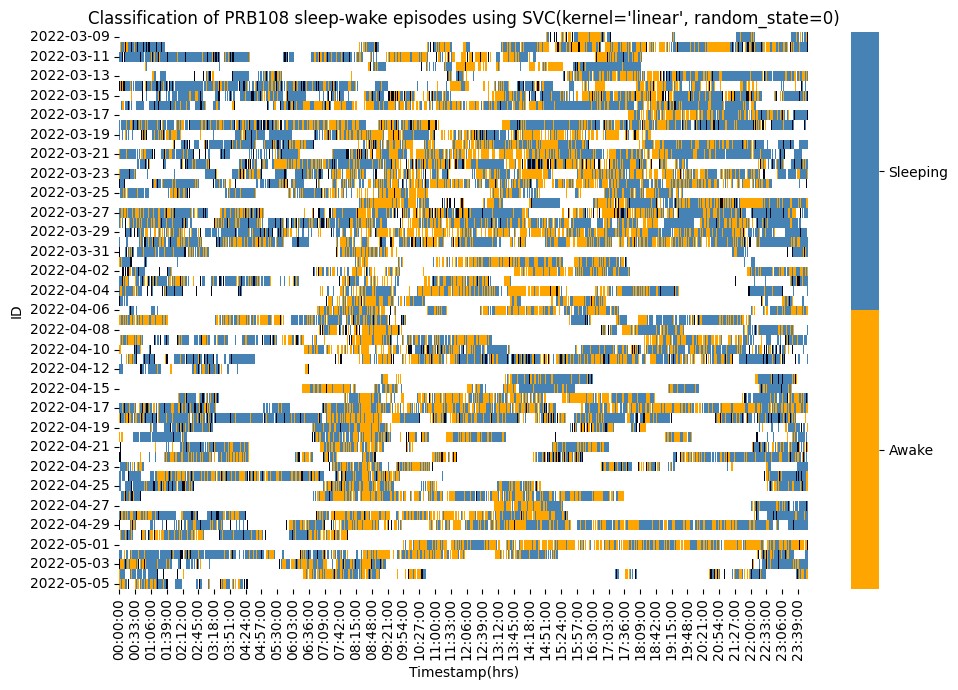

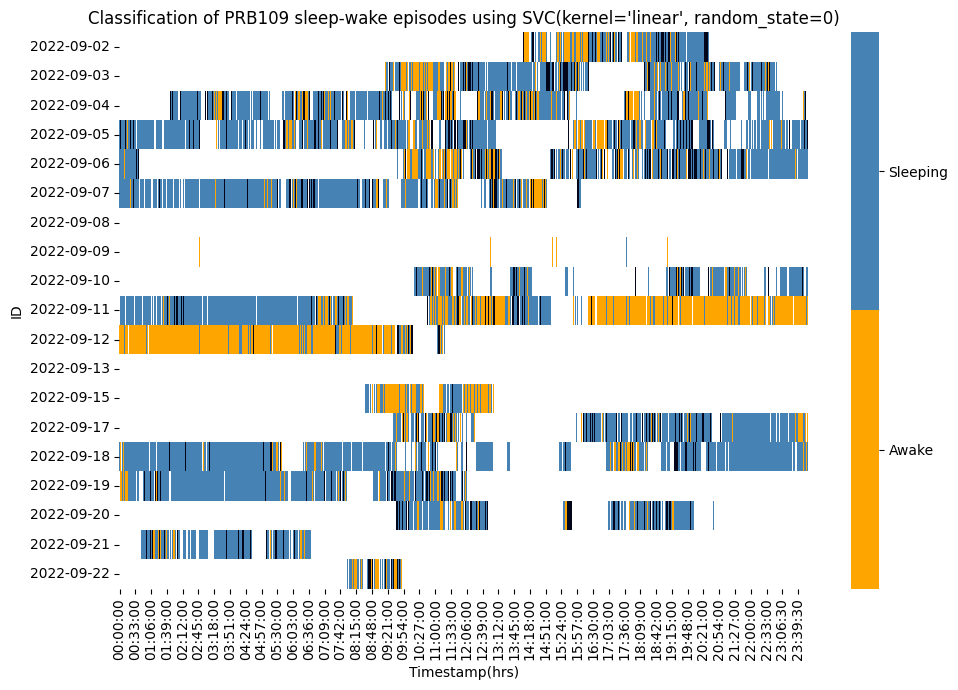

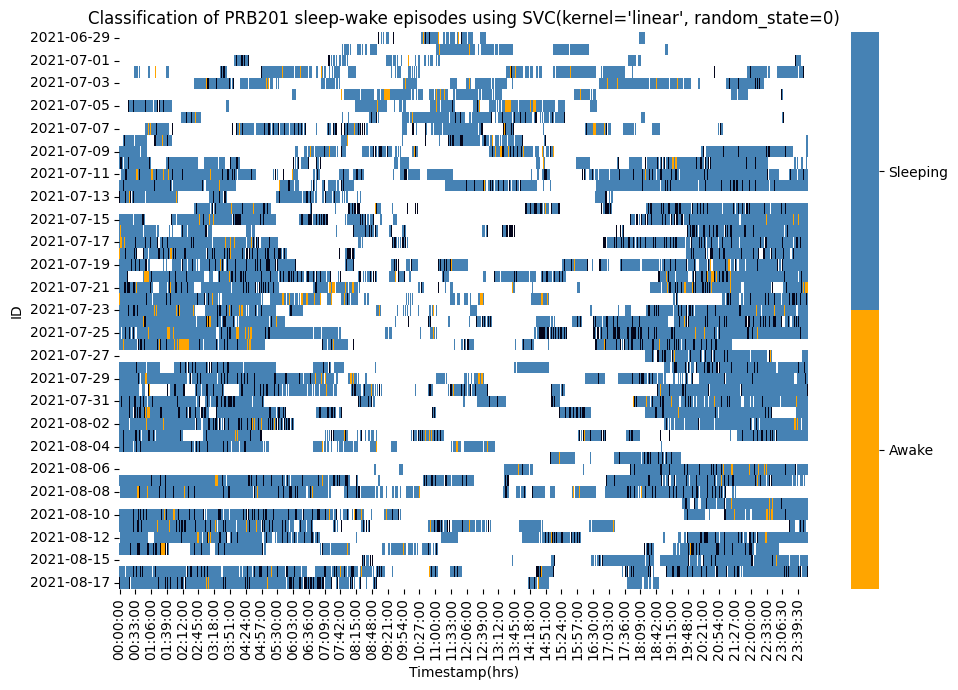

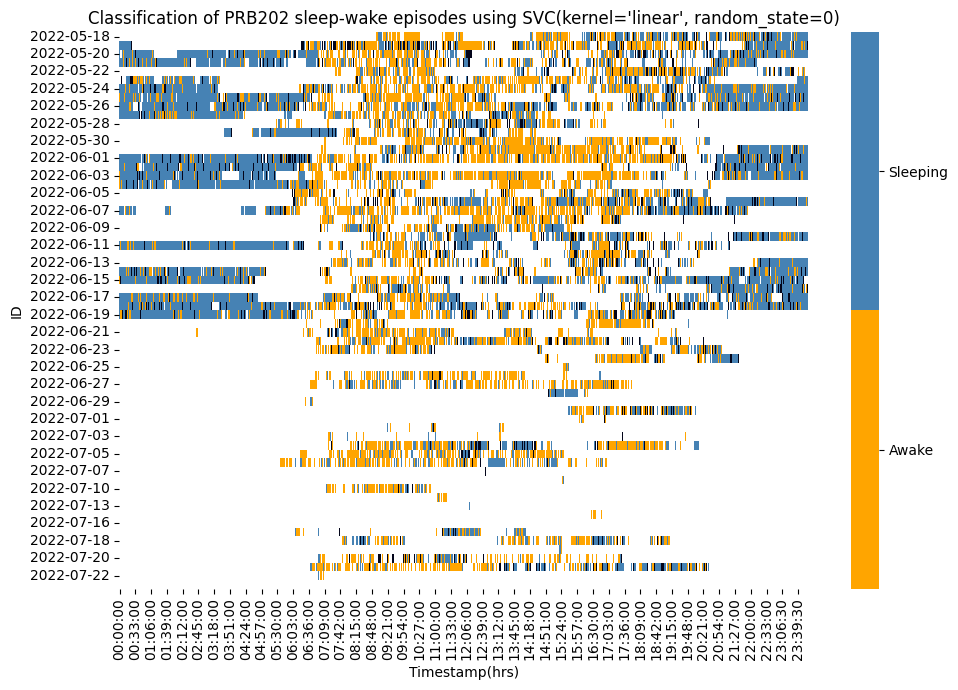

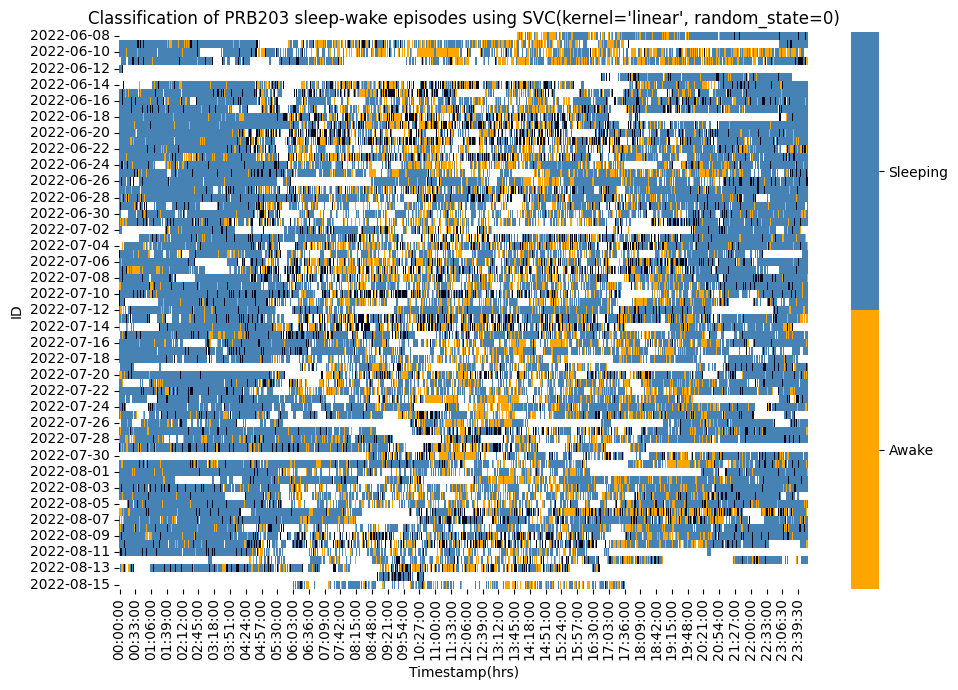

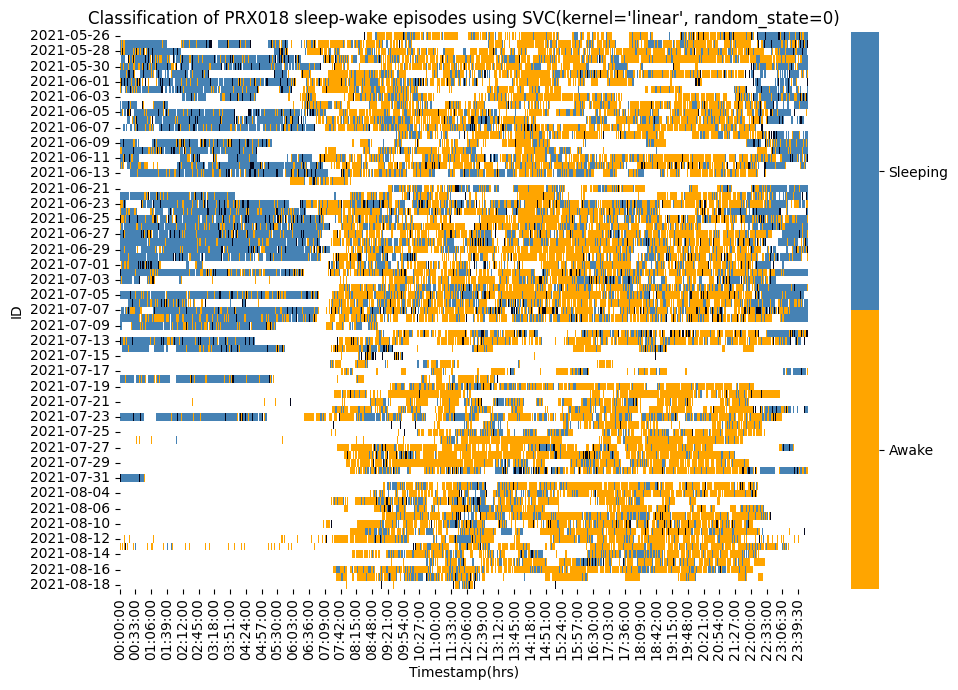

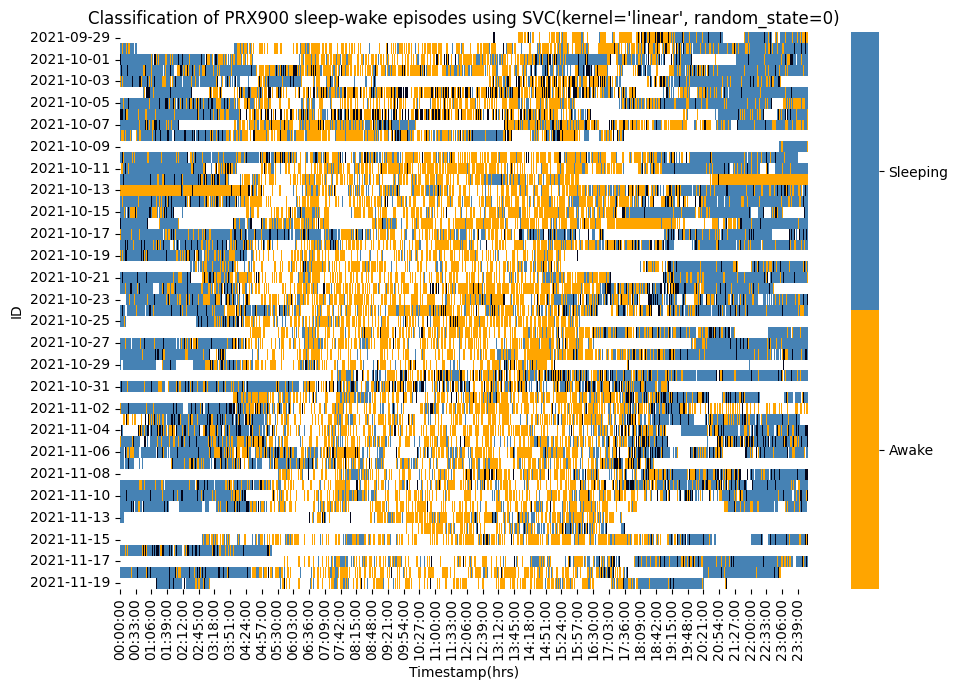

In [55]:
for id in ids:
    df = pd.read_csv(f"results/NHS/SleepAwake/{id}_semi.csv", parse_dates=["timestamp"], index_col=["timestamp"])
    df['position_change'] = df['final_class'] != df['final_class'].shift()
    df['position_change'] = df['position_change'].astype(int).replace(0, np.nan)

    heat_map = df.groupby([df.index.date, df.index.time])['isSleep'].mean().unstack()
    position_map = df.groupby([df.index.date, df.index.time])['position_change'].mean().unstack()
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(heat_map, vmin = 0, vmax = 1, cmap=sns.color_palette(['orange', 'steelblue']))
    sns.heatmap(position_map, cbar=False)
    ax.set_ylabel("ID")
    ax.set_xlabel("Timestamp(hrs)")
    ax.set_title(f"Classification of {id} sleep-wake episodes using {model}")
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(["Awake", "Sleeping"])
    plt.tight_layout()

## Accuracy comparison

In [160]:
models = ['SVM-Linear', 'SVM-RBF', 'k-means \n clustering', 'Expectation \n Maximization', 'k-means + SVM', 'EM + SVM']
acc = [91.68, 93.25, 88.24, 89.96, 93.75, 90.62]
new_acc = [91.68, 93.25, 90.09, 91.25, 95.90, 91.80]
df_acc = pd.DataFrame({'model': models, 'accuracy (%)': acc, 'new accuracy (%)': new_acc})
df_acc

model  accuracy (%)  new accuracy (%)
0                   SVM-Linear         91.68             91.68
1                      SVM-RBF         93.25             93.25
2        k-means \n clustering         88.24             90.09
3  Expectation \n Maximization         89.96             91.25
4                k-means + SVM         93.75             95.90
5                     EM + SVM         90.62             91.80

[]

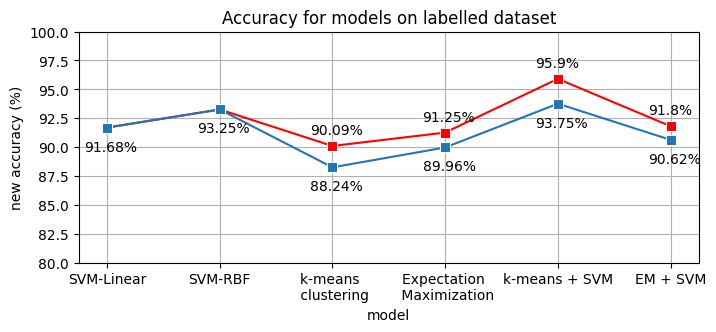

In [161]:
fig = plt.subplots(figsize=(8, 3))
sns.lineplot(data=df_acc, x="model", y="new accuracy (%)", marker='s', markersize=7, color='red')
for i in range(2, 6):
    accuracy = df_acc["new accuracy (%)"][i]
    plt.text(i-0.2, accuracy+1, f"{accuracy}%")
sns.lineplot(data=df_acc, x="model", y="accuracy (%)", marker='s', markersize=7)
for i in range(6):
    accuracy = df_acc["accuracy (%)"][i]
    plt.text(i-0.2, accuracy-2, f"{accuracy}%")
plt.title("Accuracy for models on labelled dataset")
plt.ylim(80, 100)
plt.grid()
plt.plot()

## Others

In [ ]:
df = pd.read_csv(f"E:/UG4data/NHS_r1min/PRB001(1)_r1min.csv", parse_dates=["timestamp"])
df["timestamp"].iloc[-1], df["timestamp"].iloc[-1].time() < pd.Timestamp('23:00:00').time()

In [ ]:
files = [f[:-14] for f in os.listdir("results/NHS/HAR_resampled") if f.startswith("PRB109")]
for long_id in files:
    df = pd.read_csv(f"E:/UG4data/NHS_r1min/{long_id}_r1min.csv", parse_dates=["timestamp"])
    print(f"Recording period for {long_id}:")
    print(df["timestamp"].iloc[0])
    print(df["timestamp"].iloc[-1])